In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from StochasticForceInference.StochasticForceInference import *
from scipy.io import loadmat, savemat
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, minimize, least_squares
from scipy.integrate import trapz
from scipy.stats import norm, kurtosis
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()


In [2]:
from StochasticForceInference.fun_SFI import Compute_diffusion

In [3]:
#axes.xaxis.set_tick_params(direction='in', which='both')
#axes.yaxis.set_tick_params(direction='in', which='both')
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
#c('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')
def cm2inch(value):
    return value/2.54

In [4]:
raw_data = loadmat('fit_result_15kPa_01102020_n1p609_r1p504_fix_0p052_wav_532.mat')["data"][:,0:3]
#raw_data = raw_data[45000:,:]
#raw_data = raw_data[1:,:]

r = 1.504*1e-6
n_part =  1.1609
fps = 60
time = np.arange(0,np.shape(raw_data)[0])/fps


# Data exploration


In [5]:
dataset = {} # Dataset where we will store the different fitted data in order to fit everything at the end
dataset["r"] = r
dataset["n"] = n_part
dataset["time"] = time
dataset["fps"] = 60

Text(0, 0.5, 'height [pixel]')

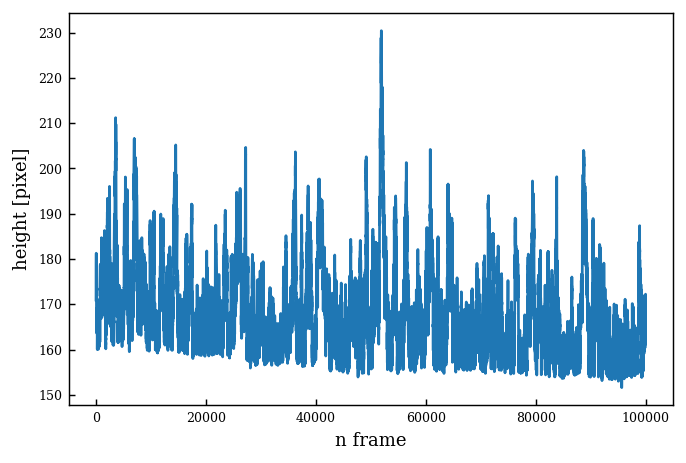

In [6]:
plt.plot(raw_data[:,2]) 
plt.xlabel("n frame")
plt.ylabel("height [pixel]")

Text(0, 0.5, 'height [pixel]')

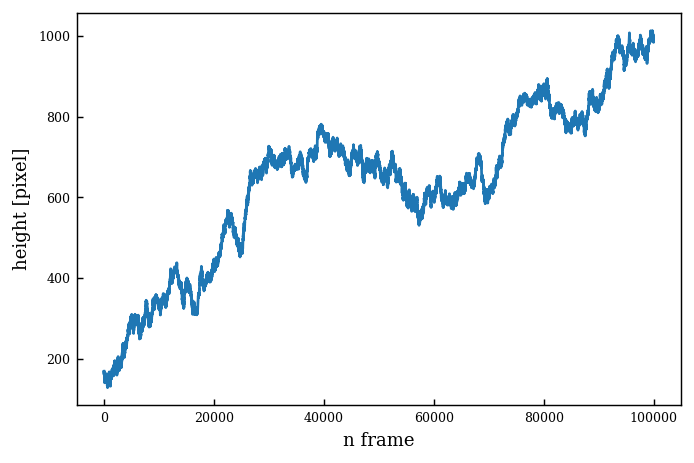

In [7]:
plt.plot(raw_data[:,0]) 
plt.xlabel("n frame")
plt.ylabel("height [pixel]")


Text(0, 0.5, 'height [pixel]')

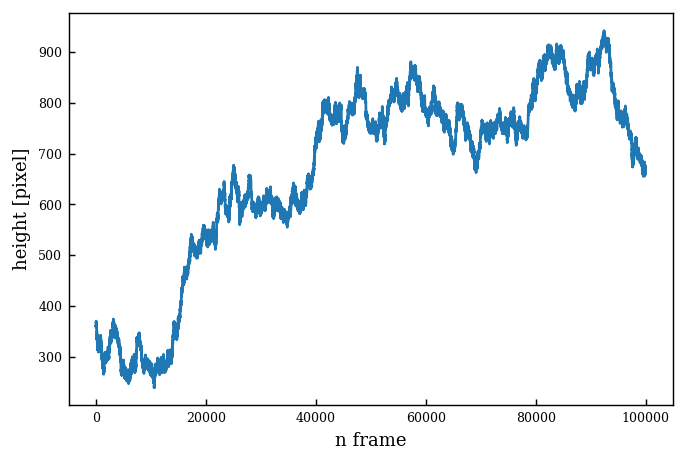

In [8]:
plt.plot(raw_data[:,1]) 
plt.xlabel("n frame")
plt.ylabel("height [pixel]")

In [9]:
#raw_data[:,2][raw_data[:,2] < 9.8] = np.nan # 

Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

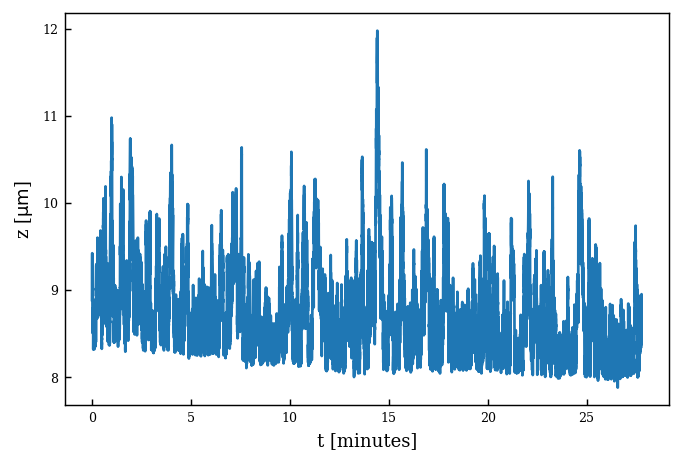

In [10]:
# We put everything in microns
raw_data_m = raw_data
raw_data_m[:,0:3] = raw_data_m[:,0:3] * 0.052
plt.plot(time/60, raw_data_m[:,2])
x = raw_data_m[:,0]
y = raw_data_m[:,1]
z = raw_data_m[:,2]

plt.xlabel("t [minutes]")
plt.ylabel("z [$\mathrm{\mu m}$]")


Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

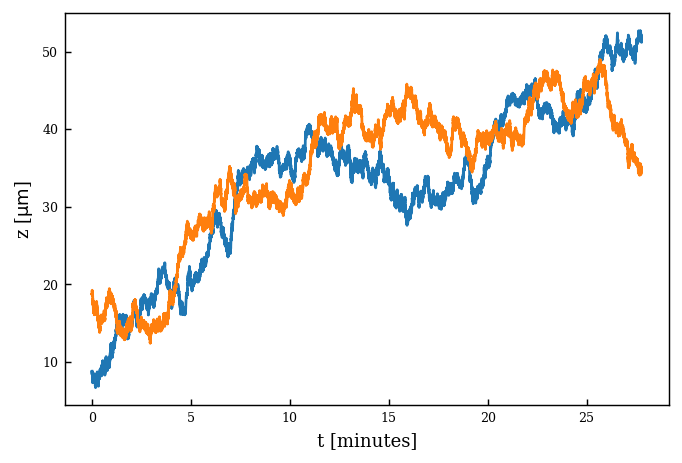

In [11]:
plt.plot(time/60, raw_data_m[:,0])
plt.plot(time/60, raw_data_m[:,1])
plt.xlabel("t [minutes]")
plt.ylabel("z [$\mathrm{\mu m}$]")

In [12]:
#N = 2000
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.ticklabel_format(style = "sci")
#for i in range(N-1):
#    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.jet(1*i/N))
    
#plt.xlabel("x [$\mathrm{\mu m}$]")
#plt.xlabel("y [$\mathrm{\mu m}$]")
#plt.xlabel("z [$\mathrm{\mu m}$]")

In [13]:
def MSD(x, t):
    MSD = np.zeros(len(t))
    for n,i in enumerate(t):
        MSD[n] = np.nanmean((x[0:-i] - x[i:]) ** 2)
    return MSD

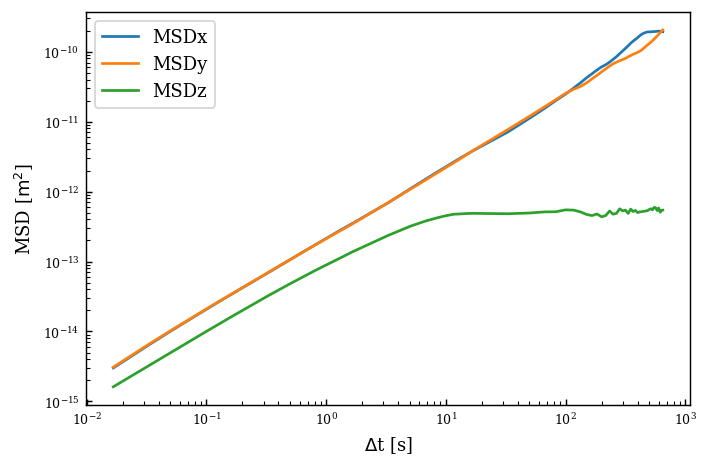

In [14]:
t = np.concatenate((np.arange(1,10, 1),np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(1000,40000, 1000)))
MSD_x = MSD(x*1e-6, t) # m² conversion
MSD_y = MSD(y*1e-6, t)
MSD_z = MSD(z*1e-6, t)


plt.loglog(time[t],MSD_x, label = "MSDx")
plt.plot(time[t],MSD_y, label = "MSDy")
plt.plot(time[t],MSD_z, label = "MSDz")
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

plt.legend()

dataset["MSD_x_tot"] = MSD_x
dataset["MSD_y_tot"] = MSD_y
dataset["MSD_z_tot"] = MSD_z
dataset["MSD_time_tot"] = time[t]



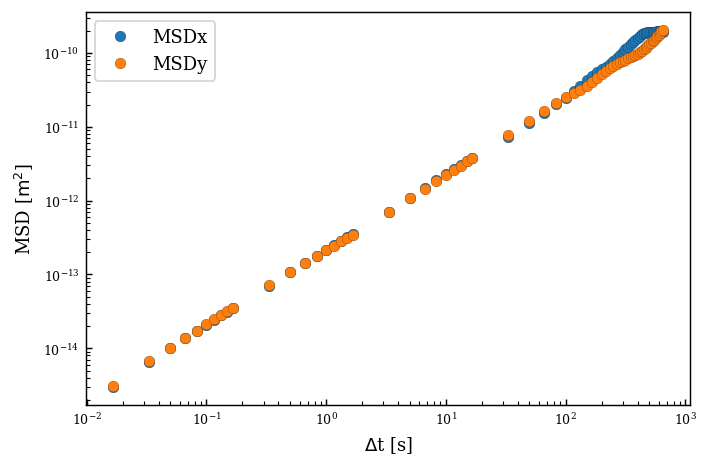

In [15]:
plt.loglog(time[t],MSD_x, "o", label = "MSDx")
plt.plot(time[t],MSD_y, "o", label = "MSDy")
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")
plt.legend()

Text(0.5, 0, '$\\Delta$t [s]')

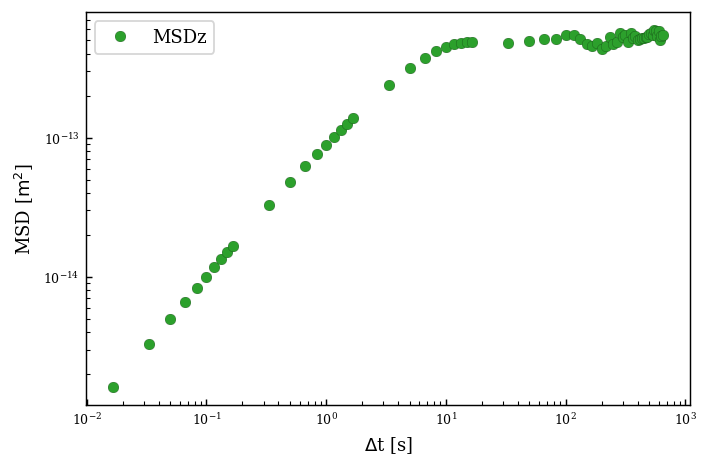

In [16]:
plt.loglog(time[t],MSD_z,"o", label = "MSDz", color = "tab:green")
plt.legend()
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

In [17]:
Do = 4e-21/(6 * np.pi * 0.001 * r)
f = lambda x,a,noiselevel : 2 * Do * a * x + (noiselevel * 1e-9) ** 2
popt_1 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_x[0:5], p0 = [1, 30])
popt_2 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_y[0:5], p0 = [1, 30])
popt_3 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_z[0:5], p0 = [1, 30])

dataset["x_MSD_fit"] = time[t[0:5]]

dataset["MSD_x"] = MSD_x[0:5]
dataset["MSD_y"] = MSD_y[0:5]
dataset["MSD_z"] = MSD_z[0:5]

/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5, 0, '$\\Delta$t [s]')

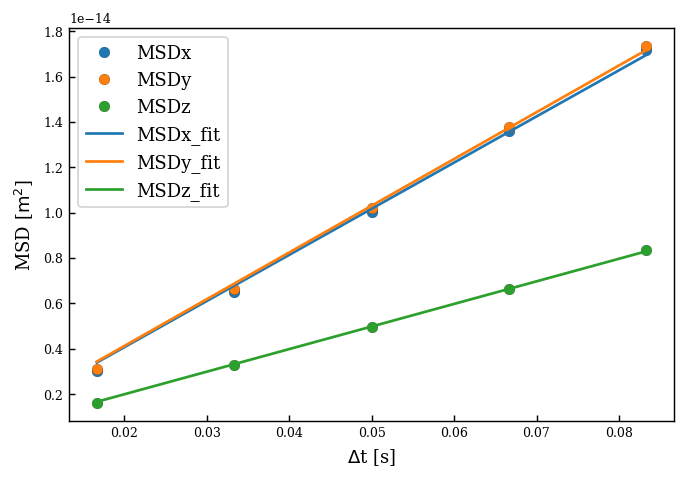

In [18]:
plt.plot(time[t[0:5]],MSD_x[0:5],"o", label = "MSDx")
plt.plot(time[t[0:5]],MSD_y[0:5],"o", label = "MSDy")
plt.plot(time[t[0:5]],MSD_z[0:5],"o", label = "MSDz")

plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_1), label = "MSDx_fit", color = "tab:blue")
plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_2), label = "MSDy_fit", color = "tab:orange")
plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_3), label = "MSDz_fit", color = "tab:green")


plt.legend()
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

In [19]:
print("We measure a reduced mean diffusion coefficient of {:.3f} for the perpendicular motion and of {:.3f} for the parallel motion".format((popt_1[0]+popt_2[0])/2, popt_3[0]))

We measure a reduced mean diffusion coefficient of 0.726 for the perpendicular motion and of 0.353 for the parallel motion


In [20]:
mean_Dz = popt_3[0]

# Pdf of the $\Delta x$

In [21]:
def pdf(data, bins = 10, density = True):
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

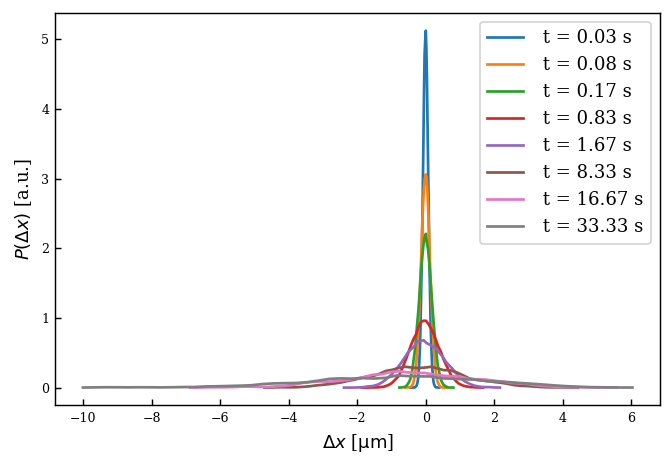

In [22]:
I = [2, 5 , 10, 50 ,100,500, 1000,2000]   

for i in I:
    
    Dezs = x[0:-i] - x[i:]
    hist, bins_center = pdf(Dezs, bins = 50)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



If we now normalize by the standard deviation


In [23]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

Text(0.5, 0, 'normalized $\\Delta x$ [a.u.]')

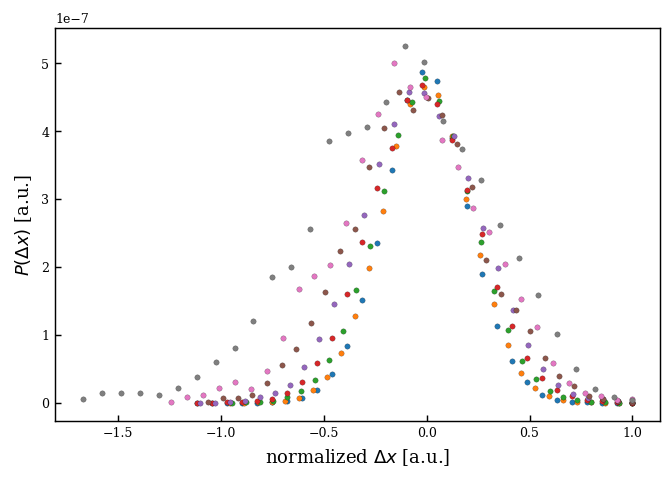

In [24]:

for n,i in enumerate(I):
    
    Dezs = (x[0:-i] - x[i:])
    Dezs = Dezs / np.sqrt(2 * Do * time[i])
    hist, bins_center = pdf(Dezs, bins = 30)

    #if i == I[0]:
    #    popt, pcov = curve_fit(gauss_function, bins_center/np.max(bins_center), hist, p0 = [1, np.mean(hist), np.std(hist)])
    #    plt.plot(bins_center/np.max(bins_center), gauss_function(bins_center, *popt), label = "fit at t = {:.2f} s".format(time[i]))
    #    plt.plot(bins_center/np.max(bins_center), hist, "x",label = " t = {:.2f} s".format(time[i]),color = "tab:blue")
    #    continue
        
    plt.plot(bins_center/np.max(bins_center), hist, ".",label = " $Delta$t = {:.2f} s".format(time[i]))
    
    
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("normalized $\Delta x$ [a.u.]")

We can observe that the kurtosis increase as we raise $\Delta t$

Text(0.5, 0, '$\\Delta t$ [s]')

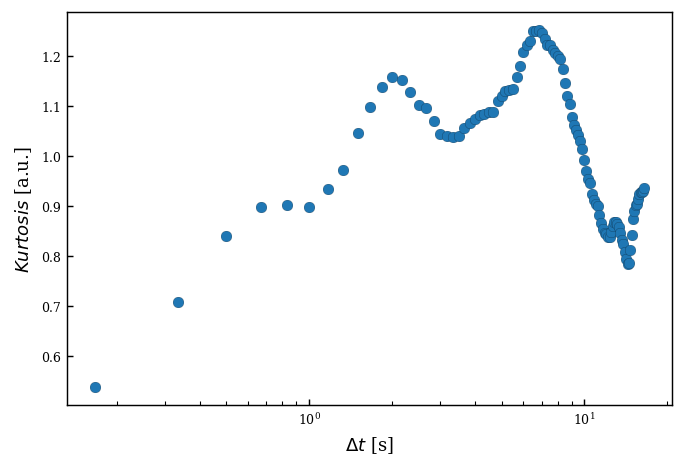

In [25]:
I = np.concatenate((
    np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(100,3500, 100)))

I = np.arange(10,1000,10)
DxKurtosis = np.zeros(len(I))

def kurtosis(x, t):
    kurtosis = np.zeros(len(t))
    for n,i in enumerate(t):
        signal = (x[0:-i] - x[i:]); signal = signal - np.mean(signal)
        kurtosis[n] = np.sum(signal ** 4 )/ np.std(signal)**4  / len(signal)
    return kurtosis



DzKurtosis = kurtosis(z,I)



plt.semilogx(time[I], DzKurtosis - 3, "o")
plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")

Text(0.5, 0, '$\\Delta t$ [s]')

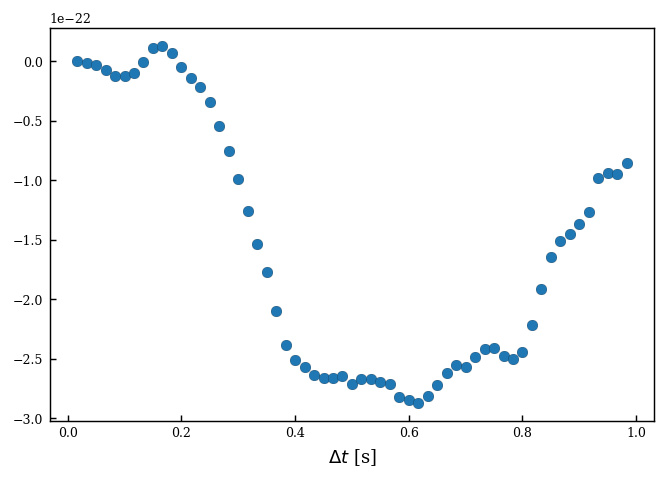

In [26]:
I = np.concatenate((
    np.arange(10,10000, 10), np.arange(100,1000, 100),np.arange(100,3500, 100)))

I = np.arange(1,60,1)
DxKurtosis = np.zeros(len(I))


def MSDn(x, t, m):
    MSD = np.zeros(len(t))
    for n,i in enumerate(t):
        MSD[n] = np.nanmean((x[i:]- x[0:-i]) ** m)
    return MSD




moment1 = MSDn(z*1e-6,I,3)



plt.plot(time[I], moment1, "o")
#plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")


#for m in range(1,6):
#    plt.loglog(time[I],moments(z,I,m),label = str(m))
    
#plt.legend()
    



In [27]:
6 * 0.001 / 0.2 * np.pi * r * 1e-10 * 1e15

0.014174866052997146

In [28]:
(3.5e-22)**(1/3)

7.047298732064899e-08

We can see a clear change but we would need to average on different trajectectories to have consitant results.

# Pdf of the $\Delta z$¶


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

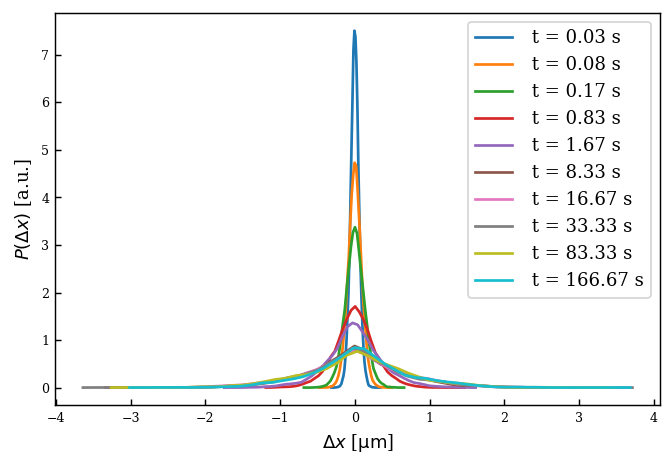

In [29]:
I = [2, 5 , 10, 50 ,100,500, 1000, 2000, 5000, 10000]   

for i in I:
    
    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 50)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

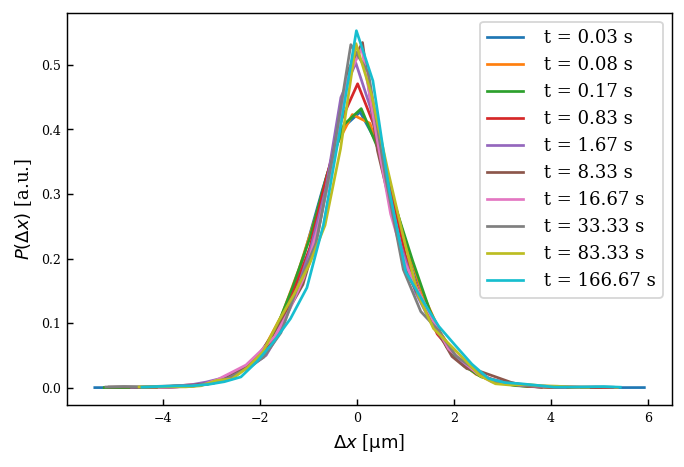

In [30]:
for i in I:
    
    Dezs = (z[0:-i] - z[i:])
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



At long time it seems non gaussian ! Let's focus on the short time


(1e-05, 1)

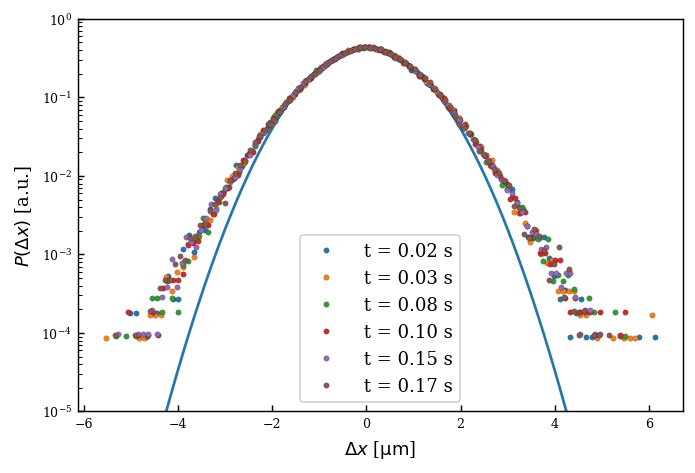

In [31]:
I = [1,2,5,6,9,10]

for i in I:
    
    Dezs = (z[0:-i] - z[i:])
    Dezs = Dezs / np.std(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 100)
    
    if i == I[0]:
        popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(hist), np.std(hist)])
        plt.plot(bins_center, gauss_function(bins_center, *popt))
        plt.plot(bins_center, hist, ".",label = " t = {:.2f} s".format(time[i]),color = "tab:blue")
        continue
    plt.semilogy(bins_center, hist, "." ,label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")
axes = plt.gca()
axes.set_ylim([1e-5,1])

In [32]:
popt

array([ 4.24189355e-01, -8.14947933e-04,  9.19915234e-01])



The non gausianity is due to the fact that the diffusion coefficient vary as a funtion of the height, thus it vary during the diffusion (diffusing diffusivity) process knowing that one can write :
\begin{equation} P(\Delta z , \Delta t) = \int_0 ^\infty dDP(D) \frac{1}{\sqrt{4 \pi D \Delta t}} exp\left[ \frac{-\Delta z ^2}{4D\Delta t} \right] \end{equation}

from Test of the diffusing-diffusivity mechanism using near-wall colloidal dynamics Mpumelelo M. et al.


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

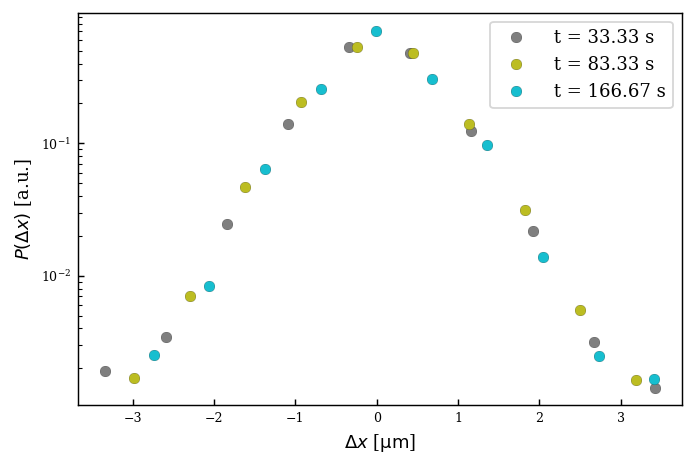

In [33]:
I = [2000, 5000, 10000]   

color_long_time = ["tab:gray","tab:olive","tab:cyan"]
for n,i in enumerate(I):
    
    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)],  bins = 10)

    plt.semilogy(bins_center, hist, "o",label = " t = {:.2f} s".format(time[i]), color = color_long_time[n])
    
plt.legend()

plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



Indeed at long time it becomes exponential and it's no longer dependent on $\Delta t$

At very long time intervals $\Delta t$ each position measurment can be seen as random measurment on the le Boltzman distribution. Thus, one can write the probability distribution as : \begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation}

with :
\begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}

Also, $P_B(z < 0)$

giving at long time step : \begin{equation} P(\Delta z) = A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}



## Analysis of pdf of the $\Delta z$ at large time step

To have a better data set we are going to measure the pdf of the $\Delta z$ for a lot of different time step and we arge going to average them. But first of all we need to get rid of the drifts at long time. The best way to do that is to a moving average, taking a box long enough to assume that the mean value should be equal to the equilibrium mean value. We can estimate the time over wich we have to average with the MSD of z and the time it takes to reach the plateau. Here we will look at times > at 30s


## Dedrifting the z trajectory

In [34]:
def movmean(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k / 2))

    for i in range(len(datas)):
        if i < int(np.ceil(k / 2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k / 2)):
            end_pt = len(datas)
        result[i] = np.mean(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

def movmin(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k / 2))

    for i in range(len(datas)):
        if i < int(np.ceil(k / 2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k / 2)):
            end_pt = len(datas)
        result[i] = np.min(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

In [35]:
#z_dedrift = z - movmean(z,20000)

# With the quality of the data we are just going to -min

z_dedrift = z - movmin(z,10000)

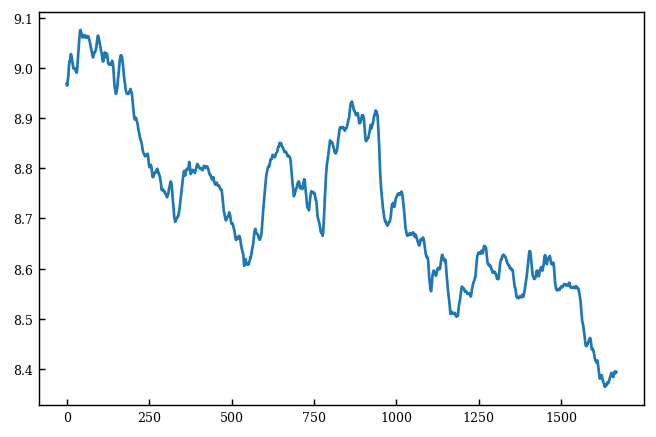

In [36]:
plt.plot(time,movmean(z,10000))

In [37]:
60000/60/60

16.666666666666668

Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

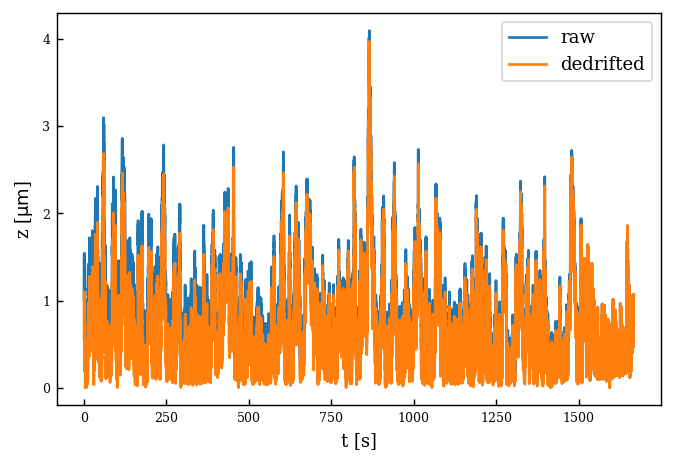

In [38]:


# Fig for comparing the two

plt.plot(time,z-np.min(z), label = "raw")
plt.plot(time,z_dedrift, label = "dedrifted")
plt.legend()

plt.xlabel("t [s]")
plt.ylabel("z [$\mathrm{\mu m}$]")

In [39]:
10000/60

166.66666666666666

Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

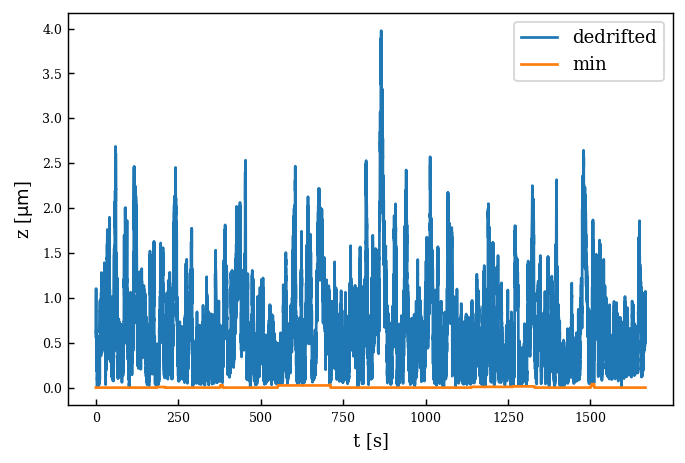

In [40]:
#plt.plot(time,z-np.min(z), label = "raw")
plt.plot(time,z_dedrift, label = "dedrifted")
plt.plot(time,movmin(z_dedrift,10000), label = "min")
plt.legend()

plt.xlabel("t [s]")
plt.ylabel("z [$\mathrm{\mu m}$]")


#z_dedrift = z_dedrift - movmin(z_dedrift,10000)

## Measuring pdf at large $\Delta t$ and analysing it

In [41]:


t_start = 25
t_end = 30
I = np.arange(t_start*fps,t_end*fps) 
bins = 50

hists = np.zeros((bins,len(I)))
bins_centers = np.zeros((bins,len(I)))

for n,i in enumerate(I):
    
    Dezs = z_dedrift[0:-i] - z_dedrift[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)],  bins = bins)
    
    hists[:,n] = hist
    bins_centers[:,n] = bins_center

    
pdf_long_t = np.mean(hists, axis = 1)
bins_centers_long_t = np.mean(bins_centers, axis = 1)
err_long_t = np.std(hists, axis = 1)
err_bins_centers = np.std(bins_centers, axis = 1)

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

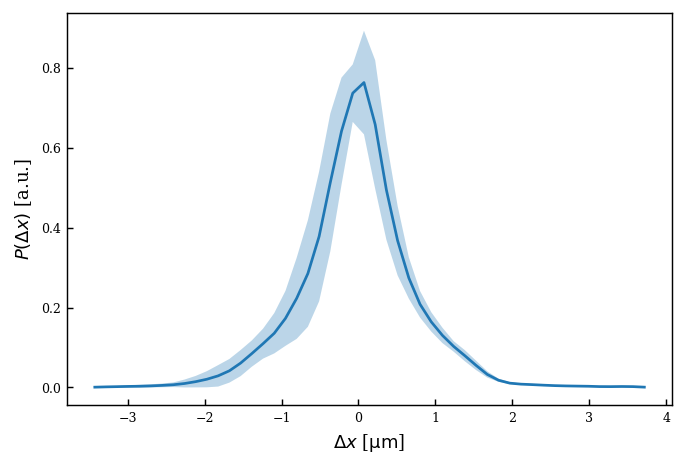

In [42]:
plt.plot(bins_centers_long_t,pdf_long_t)
plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



We are now going to code the function
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty}A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}

Noting that coding the form :
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation}

Will be easier and $P_B$ will be reused later on. Also since $P_B(z < 0) = 0$ :
\begin{equation} P(\Delta z) = \int ^ \infty _{0} dz P_B (z)P_B (z + \Delta z), \end{equation}

with :
\begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}


In [43]:
def P_b(z, A, B, ld, lb):
    P_b = A * np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0
    return P_b

def dPdeltaz_long(z, DZ, A, B, ld, lb):
    return P_b(z, A, B, ld, lb) * P_b(z + DZ, A, B, ld, lb)

def P_computation(DZ, A, B, ld, lb):
    z = np.linspace(0, 20e-6, 1000)    
    dP = dPdeltaz_long(z, DZ, A, B, ld, lb)
    P = trapz(dP,z)
    return P

def Pdeltaz_long(DZ, B, ld, lb):
    if type(DZ) == float:
        return P_computation(i, 1, B, ld, lb)
    
    pdf = np.array([P_computation(i, 1, B, ld*1e-9, lb*1e-9) for i in DZ])
    
    # normalisation of the PDF to not use A
    
    A = trapz(pdf,DZ*1e6)
    
    return np.array([P_computation(i, 1, B, ld*1e-9, lb*1e-9) for i in DZ]) / A



In [44]:
A = 0.14e8
B = 4
ld = 70
lb = 500
p1 = [B, ld, lb]

# Normalisation fo the pdf

pdf_long_t = pdf_long_t / trapz(pdf_long_t,bins_centers_long_t)


popt, pcov = curve_fit(Pdeltaz_long, bins_centers_long_t * 1e-6,pdf_long_t,p0 = p1)
dataset["pdf_longtime"] = pdf_long_t
dataset["x_pdf_longtime"] = bins_centers_long_t * 1e-6


/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [45]:
popt

array([  8.23111363, 105.75062428, 517.09815251])

Text(0.5, 0, '$\\Delta z$ [$\\mathrm{\\mu m}$]')

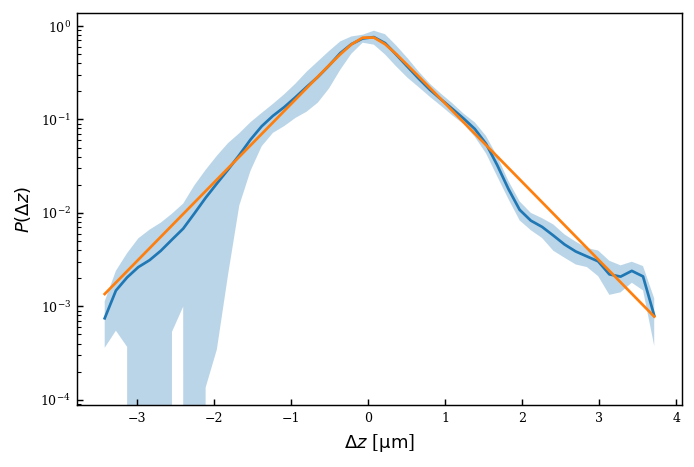

In [46]:
A = 0.14e8
B = 400
ld = 70
lb = 500
p0 = [B, ld, lb]


plt.semilogy(bins_centers_long_t,pdf_long_t, label = "experimantal pdf")
plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)

plt.plot(bins_centers_long_t,Pdeltaz_long(bins_centers_long_t*1e-6, *popt), label = "fit")
plt.ylabel("$P(\Delta z)$")
plt.xlabel("$\Delta z$ [$\mathrm{\mu m}$]")

In [47]:
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*popt))
B, ld, lb = popt


We measure, B = 8.23, ld = 105.75 nm, lb = 517.10 nm


## Analyse of the MSD z plateau

Text(0.5, 0, '$\\Delta$t (s)')

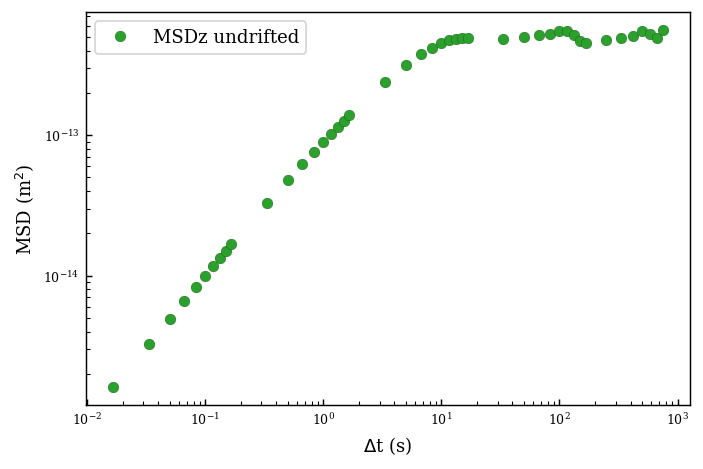

In [48]:
t = np.concatenate((np.arange(1,10, 1),np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(1000,10000, 1000),np.arange(10000,50000, 5000)))

MSD_z_dedrift = MSD(z_dedrift*1e-6, t)

plt.loglog(time[t],MSD_z_dedrift,"o", label = "MSDz undrifted", color = "tab:green")
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")


In [49]:
def func_plateau(x,P,tau):
    return P * (1 - np.exp(-x/tau))

popt, pcov = curve_fit(func_plateau, time[t], MSD_z_dedrift, p0 = [1e-12, 100])

Text(0.5, 0, '$\\Delta$t (s)')

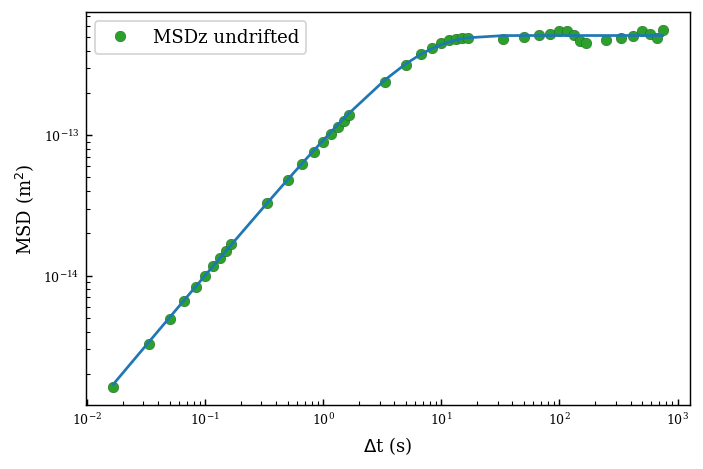

In [50]:
plt.loglog(time[t],MSD_z_dedrift,"o", label = "MSDz undrifted", color = "tab:green")
plt.plot(time[t], func_plateau(time[t], *popt))
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")


In [51]:
np.mean(MSD_z_dedrift[time[t]>1e2])

5.08188920590124e-13

In [52]:


#dataset["plateau_MSD"] = popt[0]
dataset["plateau_MSD"] =np.mean(MSD_z_dedrift[time[t]>1e2])
print("Measured plateau : {:e}".format(popt[0]))

Measured plateau : 5.115039e-13


We can compute theoretically the plateau

\begin{equation} 
Plateau = \int _{-\infty} ^{+\infty} \Delta z ^ 2 P_{\Delta z, t \rightarrow +\infty}(\Delta z,B,l_d,l_b) d\Delta z
\end{equation}

In [53]:
x_Th_Plateau = bins_centers_long_t*1e-6

def Theoritical_Plateau(B,ld,lb):
    x = dataset["x_pdf_longtime"]
    P = Pdeltaz_long(x, B, ld, lb) / trapz(Pdeltaz_long(x, B, ld, lb),x)

    res = trapz((x ** 2) * P,x)
    return res



In [54]:
def minimize_plateau(x):
    B = x[0]
    ld = x[1]
    lb = x[2]
    return (np.log(Theoritical_Plateau(B,ld,lb)) - np.log(dataset["plateau_MSD"])) ** 2 / np.log(Theoritical_Plateau(B,ld,lb))**2

In [55]:
res_plateau = minimize(minimize_plateau,x0=[B,ld,lb])

In [56]:
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*res_plateau.x))


We measure, B = 8.23, ld = 105.75 nm, lb = 517.10 nm


# Deteramination of the Vestergaard error

In [57]:
Dz_g_autocor = (z[1:] - z[:-1]) * 1e-6 ; Dz_g_autocor = Dz_g_autocor - np.mean(Dz_g_autocor)
err_z = np.sqrt(np.mean(Dz_g_autocor[1:] * Dz_g_autocor[:-1]))
err_z

4.584233830634209e-09

In [58]:
Dx_g_autocor = (x[1:] - x[:-1]) * 1e-6; Dx_g_autocor = Dx_g_autocor - np.mean(Dx_g_autocor)
err_x = np.sqrt(np.mean(Dx_g_autocor[1:] * Dx_g_autocor[:-1]))
err_x

1.5404468388128215e-08

In [59]:
Dy_g_autocor = (y[1:] - y[:-1]) * 1e-6; Dy_g_autocor = Dy_g_autocor - np.mean(Dy_g_autocor)
err_y = np.sqrt(np.mean(Dy_g_autocor[1:] * Dy_g_autocor[:-1]))
err_y

1.5171780336121816e-08

## Mesure R (tps opturation = 3ms)

In [60]:
1/60

0.016666666666666666

In [61]:
def xi(t,topt):
    
    xi = np.zeros(len(t))
    xi[t<topt] = 1/topt
    return xi

def S(t,topt):
    tt = np.linspace(0,t,10000)
    
    return np.trapz(xi(tt,topt),tt)

def R(fps,topt):
    tt = np.linspace(0,1/fps,10000)
    
    S_t = np.array([S(i,topt) for i in tt])
    to_int = S_t * (1 - S_t)
    
    return fps * np.trapz(to_int,tt)
    

In [62]:
def err_vestergaard(v,fps,topt):
    autoco_1frame = np.mean(v[1:] * v[:-1])
    std_opt = 2 * mean_Dz * Do * r * 1/fps
    sigma2 = autoco_1frame - std_opt
    
    return np.sqrt(sigma2)

    

In [63]:
topt = 3e-3
err_vestergaard(Dy_g_autocor,fps,topt)

1.517169808235017e-08

In [64]:
err_vestergaard(Dx_g_autocor,fps,topt)

1.540438737682537e-08

In [65]:
sigmaz = err_vestergaard(Dz_g_autocor,fps,topt)

In [66]:
std_opt = 2 * mean_Dz * Do * r * 1/fps

In [67]:
autoco_1frame = np.mean(Dz_g_autocor[1:] * Dz_g_autocor[:-1])
sigma2 = autoco_1frame - std_opt
np.sqrt(sigma2)

4.5839615997940445e-09


## Analyse PDF de z

In [68]:
def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist,bins = np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist

Text(0, 0.5, 'P(z) [a.u.]')

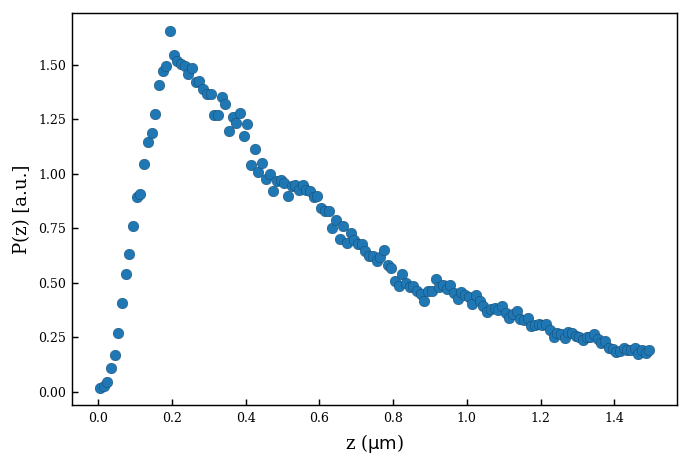

In [69]:
pdf_z, bins_center_pdf_z = pdf(z_dedrift[z_dedrift < 1.5],  bins = 150)
plt.plot(bins_center_pdf_z,pdf_z, "o")
plt.xlabel("z ($\mathrm{\mu m}$)")
plt.ylabel("P(z) [a.u.]")





The idea now is to find where the substrate is, to do this we will use a first method which consist to adjust the PDF with an offset to make it fit with the measured mean Diffusion coefficient. With :
\begin{equation} 
< D_i > = \int _{-\infty} ^{\infty} dz D_i(z)P(z) 
\end{equation}

For z we are going to use the Padé approx :
\begin{equation} D_z (z) \approx D_0 \left( \frac{6z^2 + 2rz}{6z^2 + 9rz + 2r^2} \right) \end{equation}

For x we are going to use the Faxen formula :
\begin{equation} D_x (z) \approx D_0 \left[ 1 - \frac{9}{16} \left(\frac{r}{z}\right) + \frac{1}{8} \left(\frac{r}{z}\right)^3 - \frac{45}{236} \left(\frac{r}{z}\right)^4 - \frac{1}{16} \left(\frac{r}{z}\right)^5 \right] \end{equation}

To do this we will fit the PDF with an offset, adjust it with the mean value of z. Let's first do it over z


In [70]:


def P_b_off(z,z_off,  B, ld, lb):
    z_off = z_off * 1e-6 
    lb = lb * 1e-9
    ld = ld * 1e-9
    z = z - z_off
    P_b = np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0
    
    # Normalization of P_b
    
    A = trapz(P_b,z * 1e6)
    P_b = P_b / A
    
    
    return P_b



In [71]:
#Normalization of the PDF

pdf_z = pdf_z / trapz(pdf_z,bins_center_pdf_z)


p2 = [0,B, ld, lb]

popt, pcov = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 


/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


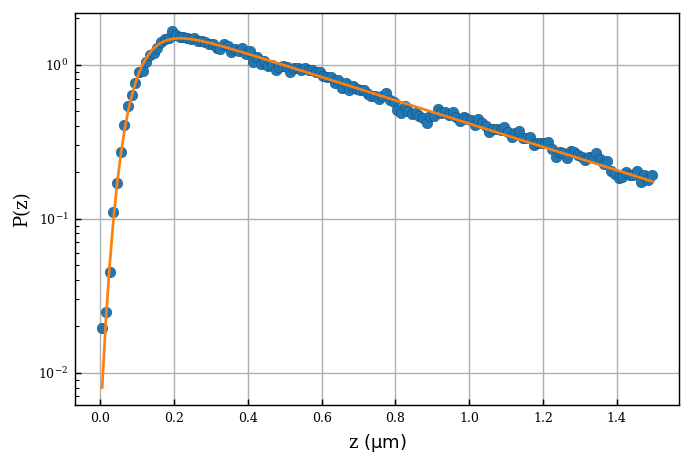

In [72]:


plt.semilogy(bins_center_pdf_z,pdf_z, "o")
plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt))

plt.xlabel("z $\mathrm{(\mu m)}$")
plt.ylabel("P(z)")
plt.grid()


In [73]:
pdf_z[pdf_z>0]

array([0.01937495, 0.02475688, 0.04520821, 0.11086775, 0.17006898,
       0.26909648, 0.40687388, 0.53926935, 0.63399131, 0.76100485,
       0.8944767 , 0.90631695, 1.04409434, 1.14527462, 1.18833006,
       1.2765937 , 1.40898917, 1.47141955, 1.49402366, 1.65763432,
       1.54784295, 1.51878053, 1.50263475, 1.49402366, 1.45957931,
       1.48864173, 1.42298219, 1.42513496, 1.391767  , 1.36485735,
       1.36701012, 1.27121177, 1.269059  , 1.3530171 , 1.32180191,
       1.19909392, 1.26260069, 1.23246188, 1.27874647, 1.17433704,
       1.23030911, 1.04194157, 1.11298304, 1.00964999, 1.04947627,
       0.9784348 , 0.99780975, 0.92138635, 0.96767094, 0.97197649,
       0.95690708, 0.89985863, 0.94291407, 0.94937238, 0.92784466,
       0.95044877, 0.92676828, 0.92353912, 0.89555309, 0.89878224,
       0.84388656, 0.82881716, 0.83096993, 0.75347014, 0.78899088,
       0.70288001, 0.75992846, 0.68350506, 0.72763688, 0.69857446,
       0.67919952, 0.6802759 , 0.64798432, 0.62215106, 0.62538

In [74]:
trapz(pdf_z,bins_center_pdf_z)

1.0



By keeping the all the result of the fit except the fit, we will check wich offset gives us the right an put the offset to 0


In [75]:


#z_dedrift = z_dedrift - popt[0]
#pdf_z, bins_center_pdf_z = pdf(z_dedrift[~np.isnan(z_dedrift)],  bins = 100)

#p2 = [np.min(bins_center_pdf_z),np.max(pdf_z),B, ld, lb]
#popt, pcov = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 

#plt.plot(bins_center_pdf_z,pdf_z, "o")
#plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt))

#plt.xlabel("Height ($\mu$m)")
#plt.ylabel("P(Height)")



In [76]:


mean_Dx = (popt_1[0]+popt_2[0])/2
mean_Dz = popt_3[0]
print("We measure a m mean diffusion coefficient of {:.3f}D0 for the perpendicular motion and of {:.3f}D0 for the parallel motion".format((popt_1[0]+popt_2[0])/2, popt_3[0]))


dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz

We measure a m mean diffusion coefficient of 0.726D0 for the perpendicular motion and of 0.353D0 for the parallel motion


In [77]:


Do = 4e-21/(6*np.pi*0.001*r)

def Dz_z(z):
    result = ((6*z*z + 2*r*z) / (6*z*z + 9*r*z + 2*r*r))
    return result
    
def Dx_z(z):
    result = (1 - 9/16*(r/(z+r)) + 1/8*(r/(z+r))**3 - 45/256*(r/(z+r))**4 - 1/16*(r/(z+r))**5)
    return result



In [78]:
mean_Dx/trapz(Dx_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,-0.3,*popt[1:]),bins_center_pdf_z)

1.402630938638255

In [79]:
def minimizer(z_off):
    Dx_pdf = trapz(Dx_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,z_off,*popt[1:]),bins_center_pdf_z)
    Dz_pdf = trapz(Dz_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,z_off,*popt[1:]),bins_center_pdf_z)
    
    return np.abs((1 - mean_Dx/Dx_pdf) + (1 - mean_Dx/Dx_pdf))
    
    
res = minimize(minimizer, 0, method='nelder-mead')

/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [80]:
offset = res

In [81]:


offset = np.mean(res["final_simplex"][0])
print("We measure an offset of {:.3f} um".format(offset))



We measure an offset of 1.486 um


In [82]:
len(bins_center_pdf_z)

150

/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0, 0.5, 'P(z)')

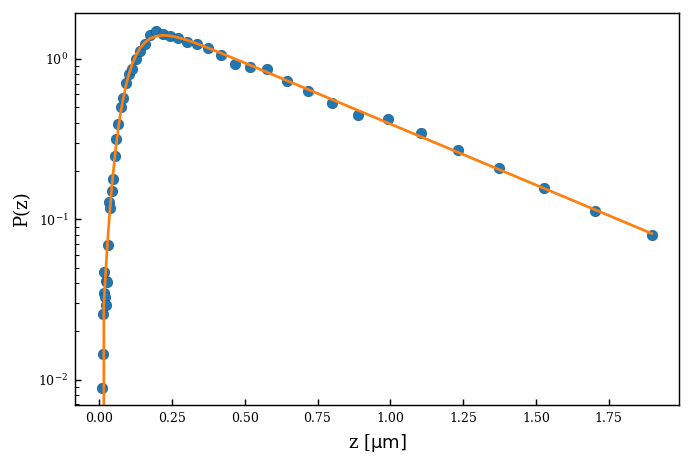

In [83]:
#z_dedrift = z_dedrift - offset
#z_dedrift[z_dedrift < 0 ] = np.nan

def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist,a= np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist



#bins_center_pdf_z,widths,hist = logarithmic_hist(z_0offset, 0.001, 3, num = 31,base=2)


#pdf_z, bins_center_pdf_z = pdf(z_dedrift[z_dedrift < 3],  bins = 100)
bins_center_pdf_z,widths, pdf_z = logarithmic_hist(z_dedrift,0.01,2,num = 50,base = 12)

p2 = [0, B, ld, lb]
popt_pdf, pcov_pdf = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 
dataset["pdf_z"] = pdf_z
dataset["x_pdf_z"] = bins_center_pdf_z * 1e-6

plt.semilogy(bins_center_pdf_z,pdf_z, "o")
plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt_pdf))

plt.xlabel("z [$\mathrm{\mu m}]$")
plt.ylabel("P(z)")

In [84]:
pdf_z

array([0.00891566, 0.        , 0.01436362, 0.02578304, 0.03471087,
       0.04673013, 0.03262066, 0.02927743, 0.04129218, 0.04042933,
       0.06954779, 0.12755385, 0.11691686, 0.15084302, 0.17854912,
       0.24829938, 0.31768213, 0.39151285, 0.49779886, 0.57018776,
       0.7025029 , 0.80170743, 0.86741566, 0.99575885, 1.12062538,
       1.24527317, 1.40603803, 1.4976768 , 1.42665586, 1.39786597,
       1.35407898, 1.26930845, 1.23111906, 1.16705621, 1.04947806,
       0.92854985, 0.89265226, 0.85925462, 0.72637837, 0.62669709,
       0.52790366, 0.44510713, 0.41925432, 0.34490016, 0.26898261,
       0.20912565, 0.15729442, 0.11261791, 0.07956934])

In [85]:
offset_pdf, B_pdf, ld_offset, lb_offset = popt_pdf

In [86]:
lb_offset

570.5983840761633

Text(0, 0.5, 'Height [$\\mathrm{ \\mu m }$]')

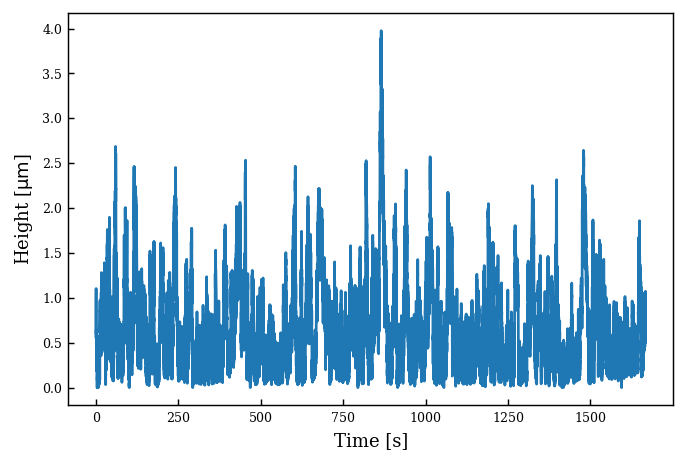

In [87]:
plt.plot(time,z_dedrift)
plt.xlabel("Time [s]")
plt.ylabel("Height [$\mathrm{ \mu m }$]")



Now that we have the deduce the offset of the trajectory we can measure the the diffusion coefficient.



# Measure of the diffusion coefficient

We are going to measure the diffusion coefficient by averaging small part of the trajectory as a function of the height.

## Measure of the perpendicular diffusion coefficient


In [88]:
def dzz():
    Y = bins_center_pdf_z * 1e-6
    z = z_dedrift * 1e-6
    Dz = np.zeros_like(Y[:-1])
    err = np.zeros_like(Y[:-1])
    
    
    for i in range(len(Y) - 1):

        with np.errstate(invalid="ignore"):
            args = np.squeeze(np.argwhere(((z > Y[i]) & (z < Y[i + 1]))))
            args = args[args < (len(z) - 10)]

            if len(args) < 10:
                Dz[i] = np.nan
                err[i] = np.nan
                continue

            trajs = np.zeros((len(args), 5))
            global_sigma = np.zeros_like(trajs[0, :])

            for n, j in enumerate(args):
                trajs[n, :] = z[j + 3 : j + 8]

            for j in range(len(trajs[0, :])):
                mu, sigma = norm.fit(trajs[:, j][~np.isnan(trajs[:, j])])
                global_sigma[j] = sigma ** 2 / 2

            func = lambda x, a, b: a * x + b
            time = np.array(range(3, 8)) / 60
            popt, pcov = curve_fit(func, time, global_sigma)
            a, b = popt
            perr = np.sqrt(np.diag(pcov))
            Dz[i] = a
            err[i] = perr[0]

    return Dz, err

In [89]:
from StochasticForceInference.fun_SFI import Compute_diffusion

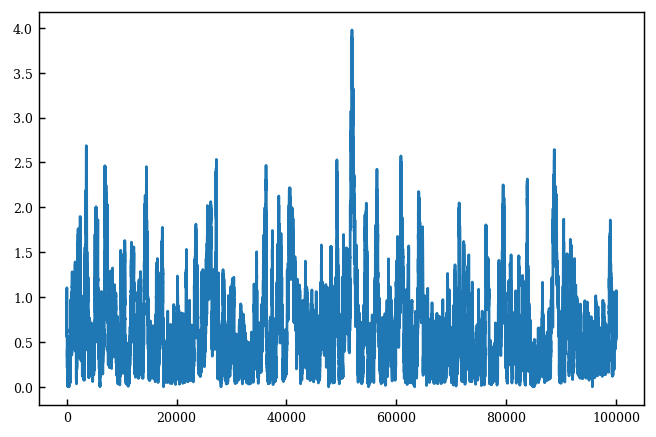

In [90]:
import matplotlib.pyplot as plt
plt.plot(z_dedrift)

In [184]:
from scipy.interpolate import UnivariateSpline
omspl = UnivariateSpline(time[::5000], raw_data_m[::5000,0], s=30)
spl2 = UnivariateSpline(time[::5000], raw_data_m[::5000,1], s=30)

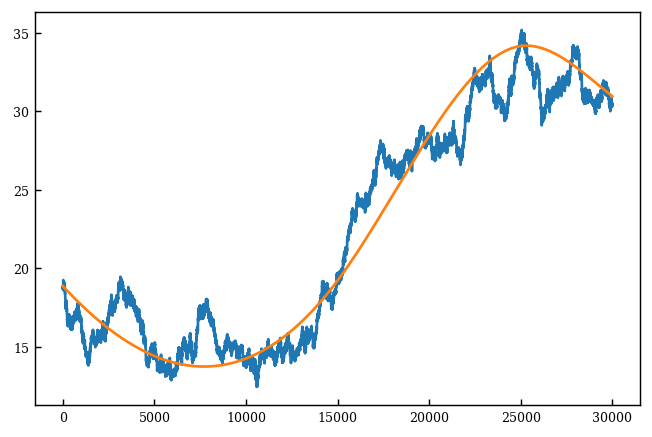

In [185]:
spl2.set_smoothing_factor(1)
plt.plot(raw_data_m[:30000,1])
plt.plot(spl2(time[:30000]))

#spl2.set_smoothing_factor(0.3)
#plt.plot(raw_data_m[:1000,1]- spl2(time[:1000]))

In [186]:
pos = np.ones((len(x),3))
y_new = raw_data_m[:,1] - spl2(time)
x_new = raw_data_m[:,0] - omspl(time)

pos[:,0] = x_new*1e-6
pos[:,1] = y_new*1e-6


pos[:,2] = z_dedrift * 1e-6

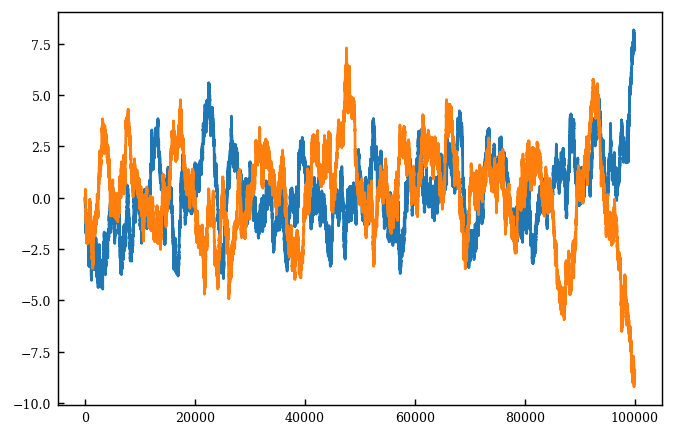

In [187]:
plt.plot(x_new)
plt.plot(y_new)

In [188]:
Dx, Dy, Dz, z_D = Compute_diffusion(pos, 1/fps, z_min = 10e-9, z_max = 1e-6, N = 100, ordre = 4)

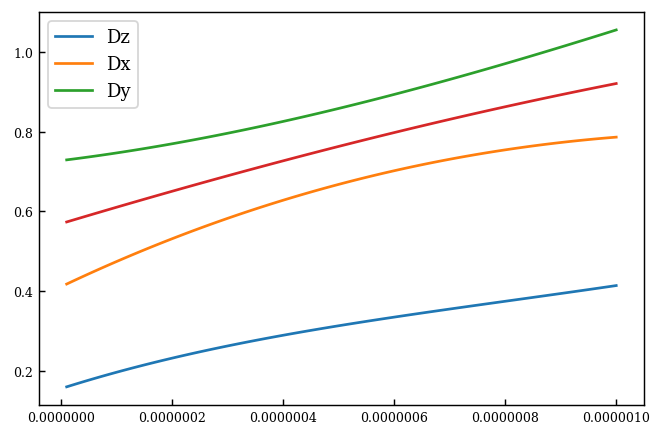

In [189]:
plt.plot(z_D, Dz/Do, label = "Dz")
plt.plot(z_D, Dx/Do, label = "Dx")
plt.plot(z_D, Dy/Do, label = "Dy")
plt.plot(z_D, (Dx+Dy)/2/Do)
plt.legend()

D_para = (Dx + Dy)/2

In [102]:


#plt.plot(bins_center_pdf_z[:-1], Dz/Do, "o")
#plt.fill_between(bins_center_pdf_z[:-1], Dz-err, Dz+err, alpha = 0.3)
#plt.errorbar(bins_center_pdf_z[:-1], Dz/Do,yerr=err/Do, linewidth = 3, marker = "o", linestyle = "")
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_\mathrm{z} (z) / D_\mathrm{0}$")





We are going to analyse the data < 1.5 um since theire is more stats it's more accurate.


In [103]:
def Dz_z(z,off):
    off =(off * 1e-6)
    z = z - off
    result = ((6*z*z + 2*r*z) / (6*z*z + 9*r*z + 2*r*r))
    return result

y_fit = Dz/Do
x_fit = z_D
popt, pcov = curve_fit(Dz_z, x_fit, y_fit, p0 = [0]) 
dataset["Dz"] = y_fit
dataset["x_fit_Dz"] = x_fit*1e-6

In [104]:
popt

array([-0.02431748])

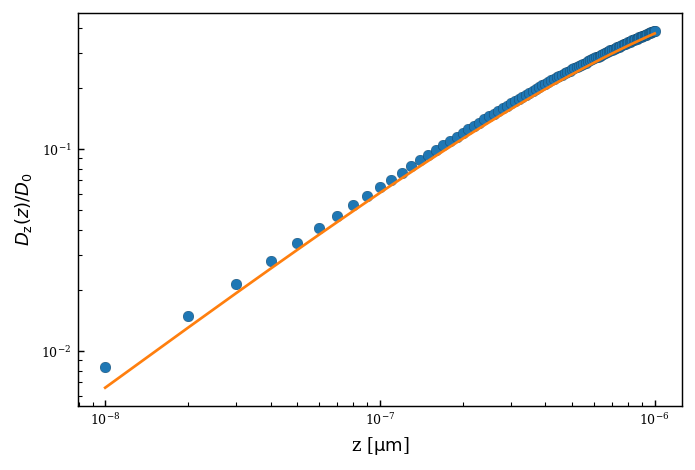

In [105]:
#plt.plot(bins_center_pdf_z[:-1], Dz, "o")
#plt.fill_between(bins_center_pdf_z[:-1], Dz-err, Dz+err, alpha = 0.3)
plt.plot(z_D, Dz/Do, linewidth = 3, marker = "o", linestyle = "")
plt.loglog(x_fit, Dz_z(x_fit,0))
plt.xlabel("z [$\mathrm{\mu m}$]")
plt.ylabel("$D_\mathrm{z} (z) / D_\mathrm{0}$")
plt.savefig("Dzz.png")

In [106]:
popt

array([-0.02431748])

## Measure of the perpendicular diffusion coefficient
We are now going to do the same computation but along x and y

In [107]:


def Dx_z_off(z,offset):
    offset = offset * 1e-6
    z = z + offset # We force an positive offset, meaning the trajectory si to low
    result = (1 - 9/16*(r/(z+r)) + 1/8*(r/(z+r))**3 - 45/256*(r/(z+r))**4 - 1/16*(r/(z+r))**5)
    return result



In [108]:
popt, pcov = curve_fit(Dx_z_off, z_D, D_para/Do, p0 = [0]) 
dataset["Dx"] = D_para
dataset["x_fit_Dx"] = z_D


In [109]:
popt

array([2.99027209])

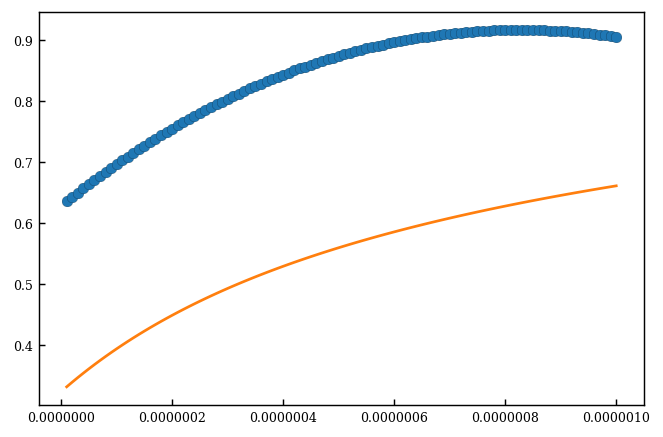

In [110]:


plt.errorbar(z_D, D_para/Do, linewidth = 3, marker = "o", linestyle = "")
plt.plot(z_D, Dx_z_off(z_D,0))
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")
#plt.savefig("Dxy")


## taking the Yacines's data

In [111]:
from scipy.io import loadmat
#D_yacine = loadmat("../data/diffusionAnalysis.mat")["diffusion"]
#dataset["z_D_yacine"] = D_yacine[:,0] + 17.94*1e-9
#dataset["z_D_x_yacine"] = (D_yacine[:,1] + D_yacine[:,2])/2
#dataset["z_D_z_yacine"] = D_yacine[:,3]


dataset["z_D_yacine"] = z_D
dataset["z_D_x_yacine"] = (Dx+Dy)/2
dataset["z_D_z_yacine"] = Dz


In [112]:
def c_P_D(B,ld,lb,offset=None):
    if offset == None:
        offset = 0
        
    z = np.linspace(1e-9,15e-6,1000)
    
    P_D = Dz_z(z,offset) * Do * P_b_off(z, offset, B, ld, lb)
    
    return Dz_z(z,offset) * Do, P_D/np.trapz(P_D,z)

def _P_Dz_short_time(Dz,Dt,B,ld,lb,offset=None):
    if offset == None:
        offset = 0
    
    D_z, P_D = c_P_D(B,ld,lb,offset)
    
    P = np.trapz(P_D / np.sqrt(4 * np.pi * D_z * Dt) * np.exp(- Dz**2 / (4 * D_z*Dt)),D_z)
    
    return P

def P_Dz_short_time(Dz,Dt,B,ld,lb,offset=None):
    if offset == None:
        offset = 0
    
    P = [_P_Dz_short_time(i,Dt,B,ld,lb,offset=offset) for i in Dz]
    P = np.array(P)
    P = P / np.trapz(P,Dz)
    
    return P
    


# Fit everything in the same time !

Finaly we can fit everything in the same time to recap we have :

   - MSD x and MSD y => $< D >$
   - MSD z => $< D >$
   - mean $< D >$ with the pdf
   - Long time pdf $\Delta z$ => $l_d,l_b,B$
   - Pdf z => $offset,l_d,l_b, B$
   - D parallel, perp => offset

The minimizer $\chi ^2$ we are going to optimize can be written as :
\begin{equation} \chi^2 = \sum _{n = 1} ^{N} \chi_n^2 \end{equation}\begin{equation} \chi_n^2 = \sum^A(n) _i = 1 \frac{1}{\sigma_{ni}}(y_{ni} - y_n(x_{ni},\boldsymbol{a}))^2 \end{equation}

with $\sigma_{ni}$ the uncertainty (can be set to 1), A the number of point in the dataset for each function, $y_n$, nth equation, $\boldsymbol{a}$ the fit parameters

We have nonlinear functions so we can use the Marquardt to optimize or Nelder-Mead methods to optimize the minimizer.


In [113]:
def minimizer_diffusion_coeff(mean_D_para, mean_D_perp, z_off, B, ld, lb):
    #minimization of the mean diffusion coefficient measurement with the PDF and MSD
    a = trapz(Dx_z_off(bins_center_pdf_z*1e-6, z_off) * P_b_off(bins_center_pdf_z*1e-6,z_off, B, ld, lb),bins_center_pdf_z)
    b = trapz(Dz_z(bins_center_pdf_z*1e-6, z_off) * P_b_off(bins_center_pdf_z*1e-6,z_off, B, ld, lb),bins_center_pdf_z)
    at = mean_Dx; bt = mean_Dz
    return (a-at)**2 / at**2 + (b-bt)**2 / bt**2
    
dataset["z"] = z_dedrift

def minimizer_Dz_small_t(B,ld,lb):
    xi = 0
    
    for n,i in enumerate([1,2,3]):
        Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
        Dezs = Dezs# - np.mean(Dezs)
        
        hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
        hist = hist/np.trapz(hist,bins_center)
        
        Dz_th = bins_center
        PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb)
        
        #xi = xi + np.nanmean((((np.abs(hist) - (PPP) ) ) ** 2) / ((np.abs(hist)**2)))
        xi = xi + np.nanmean(((hist[hist>0]-PPP[hist>0]) ** 2) / hist[hist>0]**2)
    return xi 

In [114]:
minimizer_diffusion_coeff(mean_Dx, mean_Dz, 0, B, ld, lb)

0.08039803491611044

In [115]:
minimizer_Dz_small_t(B,ld,lb)

0.6896306936373853

In [116]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    offset = x[3]
    #offset_2 = x[4]
    
  
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"], 0, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - np.log(data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / ((np.log(Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = np.log(P_b_off(data["x_pdf_z"], 0, B, ld, lb)) - np.log(data["pdf_z"])
    chi_pdf_z = np.mean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / (np.log(P_b_off(data["x_pdf_z"][E_chi_pdf_z > -np.inf], 0, B, ld, lb))**2))
    
    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = np.log(Dz_z(data["z_D_yacine"], offset)) - np.log(data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / (np.log(Dz_z(data["z_D_yacine"][E_D_z > -np.inf], offset))**2))
    
    E_D_x = np.log(Dx_z_off(data["z_D_yacine"], offset)) - np.log(data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / (np.log(Dx_z_off(data["z_D_yacine"], offset))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 

In [117]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    offset_dif = x[3]
    offset_boltz = x[4]
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"],offset_boltz, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - (data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / (((Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = (P_b_off(data["x_pdf_z"], offset_boltz, B, ld, lb) - data["pdf_z"])
    chi_pdf_z = np.nanmean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / ((P_b_off(data["x_pdf_z"], offset_boltz, B, ld, lb))**2))
    #chi_pdf_z = np.nanmean(chi_pdf_z[chi_pdf_z != np.inf])

    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = (Dz_z(data["z_D_yacine"], offset_dif)) - (data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / ((Dz_z(data["z_D_yacine"], offset_dif))**2))

    E_D_x = (Dx_z_off(data["z_D_yacine"], offset_dif)) - (data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / ((Dx_z_off(data["z_D_yacine"], offset_dif))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    #return P_b_off(data["x_pdf_z"], offset, B, ld, lb)
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z +  chi_Dz_small_t + chi_D_z + chi_D_x
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t

    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  summ 

In [118]:
B = B_pdf
ld = ld_offset
lb = lb_offset
x0 = [ld,lb,B,0,0]
x0

[53.254963527487725, 570.5983840761633, 4.425519281127333, 0, 0]

In [119]:
minimizer(x0)

1.5114282684319245

In [120]:
from scipy.optimize import leastsq

options={
    'maxc1or': 30, 
    'ftol': 2.220446049250313e-10, 
    'gtol': 1e-5, 
    'eps': 1e-08, 
    'maxfun': 15000, 
    'maxiter': 15000,
    'maxls': 20, 
    'finite_diff_rel_step': None,
}


#bnds = ((0, 1), (0, 1), (0, 30), (1, None), (1, None),(1, None),(10, 20),(40, 200),(400, 600),(0, 0.1))
bnds = ((10,70),(450,550),(10,70),(-0.05,0.05),(-0.05,0.05))


res = minimize(minimizer,
                   x0,
                   method = "BFGS",
                   tol = 0.2,
                  )

#for i in range(30):
#    print(res.fun)
#    res = minimize(minimizer,
#                   res.x,
#                   method = "L-BFGS-B",
#                   tol = 1e-1,
#                   bounds = bnds,
#                  )




#res = leastsq(minimizer, x0)


/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [121]:
res

      fun: 1.5114282684319245
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([-7.26974010e-03, -1.74017251e-03, -1.06885225e-01, -2.44735211e-01,
       -7.66363175e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 6
   status: 2
  success: False
        x: array([ 53.25496353, 570.59838408,   4.42551928,   0.        ,
         0.        ])

In [122]:


res.x
results = {
    "ld":res.x[0],
    "lb":res.x[1],
    "B":res.x[2],
    "offset_diffusion":res.x[3],
    "offset_boltzmann":res.x[4], 
}

results

{'ld': 53.254963527487725,
 'lb': 570.5983840761633,
 'B': 4.425519281127333,
 'offset_diffusion': 0.0,
 'offset_boltzmann': 0.0}

In [123]:
4e-21 / (4/3*np.pi*50*(1.516e-6)**3*9.81) * 1e9

558.7721683929958

In [124]:
#ftol = 2.220446049250313e-10
#dataset["results"] = results
#dataset["results_err"] = np.sqrt(max(1, abs(res.fun)) * ftol * np.diag(res.hess_inv.todense()))

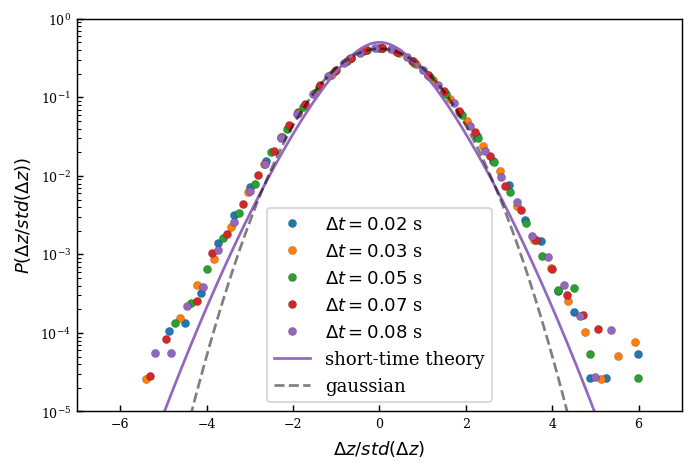

In [125]:
dataset["z"] = z_dedrift
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
    Dezs = Dezs# - np.mean(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    dataset["pdf_Dz_short_t_{}".format(i)] = [bins_center/np.std(Dezs),hist/np.trapz(hist,bins_center/np.std(Dezs))] 
    plt.plot(bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    if i == 5:
        Dz_th = np.linspace(2*np.min(Dezs), 2*np.max(Dezs),1000)
        popt, pcov = curve_fit(gauss_function,bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), p0 = [1, 1, 1])
        PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb,offset=0)
        
        z_gauss = np.linspace(-10,10,1000)


z_gauss = np.linspace(-10,10,1000)

plt.semilogy(Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs)),color = color[n],label="short-time theory")
dataset["pdf_Dz_short_th_t_{}".format(i)] = [Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs))]
plt.plot(z_gauss, gauss_function(z_gauss, *popt), markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
dataset["gaussia_short_timetheory"] = [z_gauss, gauss_function(z_gauss, *popt)]
plt.legend()
ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-7,+7])
plt.xlabel("$\Delta z/std( \Delta z)$")
plt.ylabel("$P(\Delta z/std(\Delta z))$")
plt.savefig("pdf_Delta_z_tps_courts_normalized.pdf")

In [126]:
#dataset["results_err"]

In [127]:
ld = res.x[0]
lb = res.x[1]
B = res.x[2]
offset_diffusion = res.x[3]
offset_B = res.x[4]

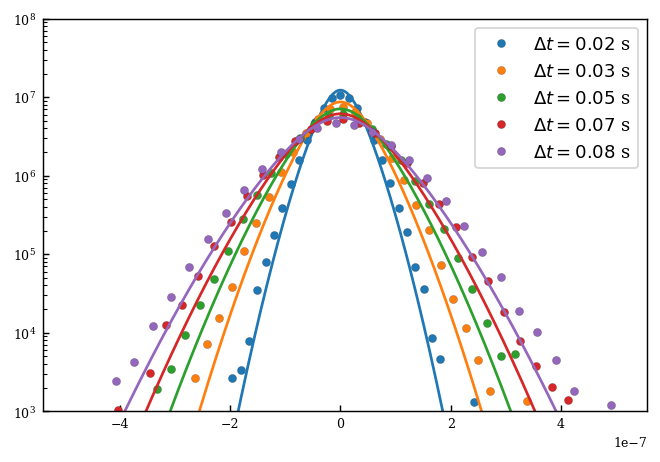

In [128]:
dataset["z"] = z_dedrift
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
    Dezs = Dezs# - np.mean(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    plt.plot(bins_center, hist, ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    Dz_th = np.linspace(np.min(Dezs), np.max(Dezs),1000)
    PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb,offset=0)
    plt.semilogy(Dz_th,PPP,color = color[n])
    #if i == 1:
    #    popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(Dezs), np.std(Dezs)])
    

#plt.plot(bins_center, gauss_function(bins_center, *popt), markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
plt.legend()
ax = plt.gca()
ax.set_ylim([1e3,1e8])
plt.savefig("pdf_Delta_z_tps_courts.pdf")

# Distribution x and y

In [129]:
def c_P_Dx(B,ld,lb):
    z = np.linspace(1e-9,15e-6,1000)
    
    P_D = Dx_z(z) * Do * P_b_off(z, 0, B, ld, lb)
    
    return Dx_z(z) * Do, P_D/np.trapz(P_D,z)

def _P_Dx_short_time(Dx,Dt,B,ld,lb):

    D_x, P_D = c_P_Dx(B,ld,lb)
    
    P = np.trapz(P_D / np.sqrt(4 * np.pi * D_x * Dt) * np.exp(- Dx**2 / (4 * D_x*Dt)),D_x)
    
    return P

def P_Dx_short_time(Dx,Dt,B,ld,lb):

    
    P = [_P_Dx_short_time(i,Dt,B,ld,lb) for i in Dx]
    P = np.array(P)
    P = P / np.trapz(P,Dx)
    
    return P

P_Dx_short_time([1e-8,1e-9],time[4],B,ld,lb)

array([-1.10819223e+08, -1.11402999e+08])

Text(0, 0.5, '$P(\\Delta x/std(\\Delta x))$')

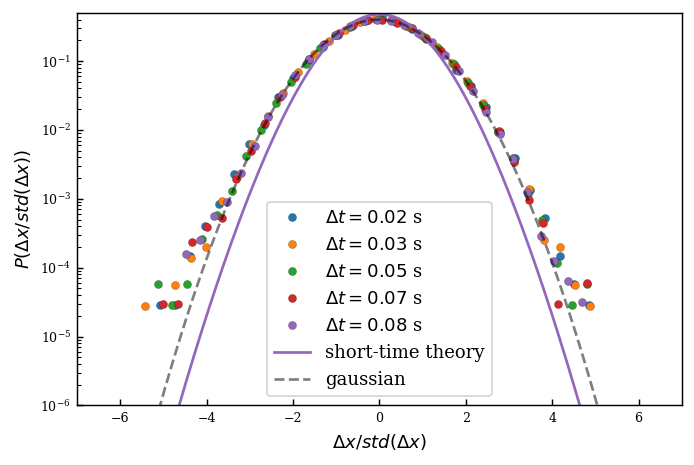

In [130]:
dataset["x"] = x
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dexs = (dataset["x"][0:-i] - dataset["x"][i:]) * 1e-6
    hist, bins_center = pdf(Dexs[~np.isnan(Dexs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    dataset["pdf_Dx_short_t_{}".format(i)] = [bins_center/np.std(Dexs),hist/np.trapz(hist,bins_center/np.std(Dexs))] 
    plt.plot(bins_center/np.std(Dexs), hist/np.trapz(hist,bins_center/np.std(Dexs)), ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    if i == 5:
        Dx_th = np.linspace(2*np.min(Dexs), 2*np.max(Dexs),1000)
        popt, pcov = curve_fit(gauss_function,bins_center/np.std(Dexs), hist/np.trapz(hist,bins_center/np.std(Dexs)), p0 = [1, 1, 1])
        PPP = P_Dx_short_time(Dx_th,time[i],B,ld,lb)
        
        x_gauss = np.linspace(-10,10,1000)


plt.semilogy(Dx_th/np.std(Dexs),PPP/np.trapz(PPP,Dx_th/np.std(Dexs)),color = color[n],label="short-time theory")
#dataset["pdf_Dz_short_th_t_{}".format(i)] = [Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs))]
plt.semilogy(x_gauss, gauss_function(x_gauss, *popt), markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
#dataset["gaussia_short_timetheory"] = [z_gauss, gauss_function(z_gauss, *popt)]
plt.legend()
ax = plt.gca()
ax.set_ylim([1e-6,0.5])
ax.set_xlim([-7,+7])
dataset["pdf_Dx_short_th_t_{}".format(i)] = [Dx_th/np.std(Dezs),PPP/np.trapz(PPP,Dx_th/np.std(Dexs))]

plt.xlabel("$\Delta x/std( \Delta x)$")
plt.ylabel("$P(\Delta x/std(\Delta x))$")
#plt.savefig("pdf_Delta_z_tps_courts_normalized.pdf")

# Premier moment

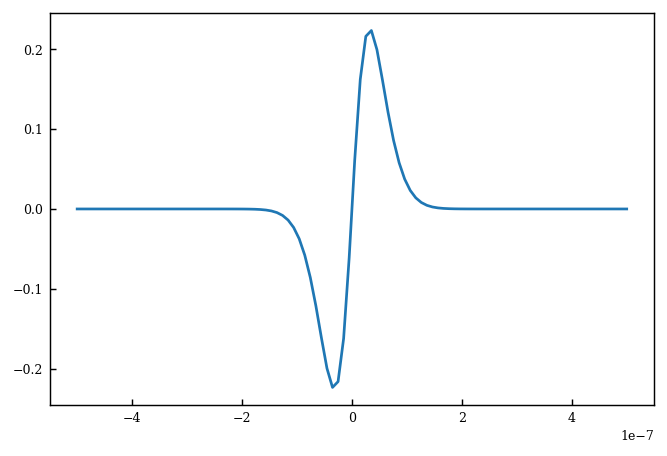

In [131]:
Dz_th = np.linspace(-5e-7,5e-7,100)


plt.plot(Dz_th,Dz_th * P_Dz_short_time(Dz_th,time[1],B,ld,lb))

In [132]:
time[1]

0.016666666666666666

In [133]:
def moment1_th_f(Dt,B,ld,lb):
    Dz_th = np.linspace(-5e-7,5e-7,100)
    

    moment = np.trapz(np.abs(Dz_th) * P_Dz_short_time(Dz_th,Dt,B,ld,lb), Dz_th)
    
    return moment
    

[]

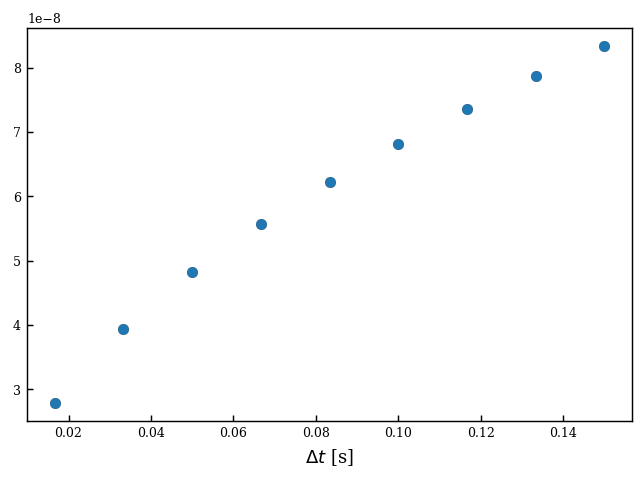

In [134]:
I = np.arange(1,10,1)

moment1_exp = MSDn(z*1e-6,I,1)


moment1_th = [moment1_th_f(i,B,ld,lb) for i in time[I]]


plt.plot(time[I], moment1_th, "o")
#plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")

plt.plot()

In [135]:
moment1_th

[2.790392788026534e-08,
 3.938689480022139e-08,
 4.8208419519119364e-08,
 5.5648697227635714e-08,
 6.220494791911028e-08,
 6.813151200414712e-08,
 7.357781590561835e-08,
 7.863916533214341e-08,
 8.33798456582223e-08]

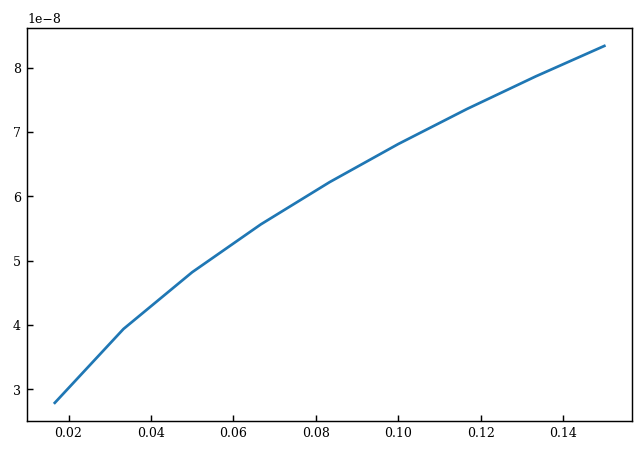

In [136]:
plt.plot(time[I], moment1_th)


In [137]:
dataset["fitted_MSD_Plateau"] = Theoritical_Plateau(B,ld,lb)
dataset["Pb_th"] = P_b_off(dataset["x_pdf_z"], 0, B, ld, lb)
dataset["MSD_fit_x"] = f(dataset["MSD_time_tot"],dataset["D_para"],0)
dataset["MSD_fit_z"] = f(dataset["MSD_time_tot"],dataset["D_perp"],0)
dataset["z_D_th"] = z_th = np.linspace(10e-9,10e-6,100)
dataset["z"] = z
dataset["offset_B"] = offset_B
dataset["err_long_t"] = err_long_t
dataset["bins_centers_long_t"] = bins_centers_long_t
dataset["Pdeltaz_long_th"] = Pdeltaz_long(bins_centers_long_t*1e-6, B, ld, lb)
dataset["D_x_th"] = Dx_z_off(z_th,0)
dataset["D_z_th"] = Dz_z(z_th,0)
dataset["offset_diffusion"] = offset_diffusion
dataset["Do"] = Do

/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:205: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


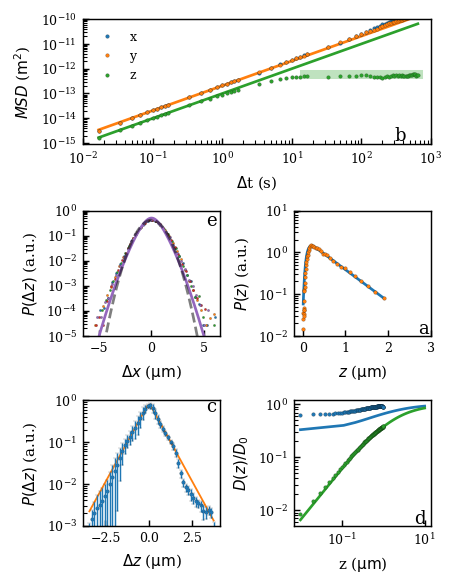

In [138]:
fig = plt.figure(figsize=(cm2inch(8.6), 1.3*cm2inch(8.6)),constrained_layout=True)
gs = fig.add_gridspec(6,6)


fig.add_subplot(gs[3:5,3:])


plt.plot(dataset["x_pdf_z"] * 1e6,dataset["Pb_th"])
plt.semilogy(dataset["x_pdf_z"] * 1e6 - dataset["offset_B"],dataset["pdf_z"], "o", markersize = 2)

plt.xlabel("$z$ ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$P(z)$ (a.u.)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-2,10])
ax.set_xlim([-0.2,2])
plt.xticks([0,1,2,3])

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()



plt.text(0.9*xmax,1.1*ymin,'a')


##### MSD


fig.add_subplot(gs[0:2,0:])



plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_x"], color = "tab:orange")
plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_z"], color = "tab:green")

plt.loglog(dataset["MSD_time_tot"],dataset["MSD_x_tot"],"o", label = "x", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_y_tot"],"o", label = "y", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_z_tot"],"o", label = "z", markersize = 2)




# plateau

plateau = [dataset["fitted_MSD_Plateau"] for i in range(len(dataset["MSD_time_tot"]))]
plt.loglog(dataset["MSD_time_tot"][-40:], plateau[-40:], color = "tab:green", linewidth = 5, alpha = 0.3)
                               
    
##
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.set_xlim([1e-2,1e3])
ax.set_ylim([None,1e-10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.3*xmax,1.35*ymin,'b')


plt.ylabel("$MSD$ ($\mathrm{m^2}$)",fontsize = "small")
plt.xlabel("$\Delta$t (s)",fontsize = "small")

plt.legend(frameon = False,fontsize = "x-small",loc = "upper left")

##### PDF DZ long time



fig.add_subplot(gs[4:,0:3])

plt.errorbar(dataset["x_pdf_longtime"]*1e6,dataset["pdf_longtime"],yerr=err_long_t,barsabove=True,linewidth = 0.8, label = "experimental pdf",marker="o", markersize=2,capsize = 1,linestyle="")
#plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.semilogy(dataset["bins_centers_long_t"],dataset["Pdeltaz_long_th"], linewidth = 1, zorder=-1)


plt.ylabel("$P(\Delta z)$ (a.u.)",fontsize = "small")
plt.xlabel("$\Delta z$ ($\mathrm{\mu m}$)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,1])
#ax.set_xlim([None,1e-10])

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.55*ymax,'c')


#### VISCOSITY

z_th = np.linspace(10e-9,10e-6,100)
fig.add_subplot(gs[4:,3:])

#plt.errorbar(z_D_para_fit, D_para_fit/Do, yerr = err_d_para_fit/Do, linewidth = 3, marker = "x", linestyle = "",color = "tab:red", label = "$D_ \\parallel$")
plt.loglog(z_th*1e6, dataset["D_x_th"], color = "tab:blue")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion*0, dataset["z_D_x_yacine"] / Do, marker = "o", linestyle = "",color = "tab:blue",label =  "$D_\\parallel$", markersize = 2)



#plt.errorbar(bins_center_pdf_z[:-1], Dz[:]/Do, yerr=err[:]/Do, linewidth = 3, marker = "o", linestyle = "",color = "tab:red",label =  "$D_ \\bot$")
plt.semilogx(z_th*1e6, dataset["D_z_th"], color = "tab:green")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion*0, dataset["z_D_z_yacine"] / Do, marker = "o", linestyle = "",color = "tab:green",label =  "$D_ \\bot$", markersize = 2)


ax = plt.gca()
#ax.set_ylim([None,1])
#ax.set_xlim([None,10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.4*xmax,1.1*ymin,'d')


#plt.legend(frameon = False,fontsize = "x-small",loc="lower center")
plt.xlabel("z ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$D (z)/ D_\mathrm{0}$",fontsize = "small")



#### Inset

# Inset

#left, bottom, width, height = [0.26, 0.2, 0.15, 0.11]
#ax2 = fig.add_axes([left, bottom, width, height])
fig.add_subplot(gs[2:4,0:3])
I = [1, 4, 5]

for n,i in enumerate([1,2,3,4,5]):
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
    Dezs = Dezs# - np.mean(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    dataset["pdf_Dz_short_t_{}".format(i)] = [bins_center/np.std(Dezs),hist/np.trapz(hist,bins_center/np.std(Dezs))] 
    plt.plot(bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 2.5,color = color[n])
    if i == 5:
        Dz_th = np.linspace(2*np.min(Dezs), 2*np.max(Dezs),1000)
        popt, pcov = curve_fit(gauss_function,bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), p0 = [1, 1, 1])
        PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb,offset=0)
        
        z_gauss = np.linspace(-10,10,1000)


z_gauss = np.linspace(-10,10,1000)

plt.semilogy(Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs)),color = color[n],label="short-time theory")
dataset["pdf_Dz_short_th_t_{}".format(i)] = [Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs))]
plt.plot(z_gauss, gauss_function(z_gauss, *popt), markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
dataset["gaussia_short_timetheory"] = [z_gauss, gauss_function(z_gauss, *popt)]
ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-6.5,6.5])
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())

#plt.legend(fontsize = "xx-small", frameon = False)
plt.ylabel("$P(\Delta z)$ (a.u.)", fontsize = "small")
plt.xlabel("$\Delta x$ ($\mathrm{\mu m}$)", fontsize = "small")


#plt.subplot(3,3,2)
#plt.subplot(3,3,5)
#plt.subplot(3,3,8)

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.25*ymax,'e')

plt.tight_layout(pad = 0.1)

plt.savefig("graphe.pdf",dpi=600)

In [139]:
offset_diffusion

0.0

In [140]:
offset_B

0.0

# Measure of the drift

In [141]:
offset_diffusion

0.0

In [142]:
z_0offset = z_dedrift + offset_diffusion

def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist = np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist



bins_center_pdf_z,widths,hist = logarithmic_hist(z_0offset, 0.001, 3, num = 31,base=2)
#hist,bins_center_pdf_z = pdf(z_0offset[z_0offset < 2.5],  bins = 150)


In [143]:
def vzz(times=[1]):
    
    # We frist get all the different variables of the problem
    z = z_0offset* 1e-6
    Y = bins_center_pdf_z * 1e-6
    z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.      
    # We initialize the variable used to store the results.
    # For the diffusion coefficient itself.
    vz = np.zeros((len(times), len(Y[:-1])))

    # For the error
    errvz = np.zeros((len(times), len(Y[:-1])))
    
    
    for n, i in enumerate(times):
        
        # Conpute the Delta x = x(Dt + t) - x(t) for given Dt -- same over y
        Dzs = z_z[i:] - z_z[0:-i]
        
        # Now for each z-bin we are going to measure the diffusion coefficient.
        
        for m in range(len(Y)-1):
            
            # We take the Dx corresponding the actual bin 
            dz = Dzs[(z[range(len(Dzs))] > Y[m]) & (z[range(len(Dzs))] < Y[m+1])]
            
            
            vz[n,m] = np.mean(dz)/(i/fps)
            #errvz[n,m] = (np.std(dz))/(i/fps)
            errvz[n,m] = len(dz)
    err_vz = np.nanmean(errvz, axis=0)
    vz = np.nanmean(vz, axis=0)
          
    return vz, err_vz

In [144]:

vz2,err2 = vzz(np.arange(1,3))


/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


In [145]:
r

1.504e-06

In [146]:
from scipy. interpolate import UnivariateSpline
D_z = UnivariateSpline(z_D,Dz)

eta_z = lambda x: 4e-21 / (6 * np.pi * r * D_z(x))



def F_fictif(z):
    F = 4e-21 * (42*r*z*z + 24*r*r*z + 4*r*r*r)/(36*(z**4) + 66*r*(z**3) + 30*r*r*z*z + 4*(r**3)*z)
    
    return F

z_F_exp = (bins_center_pdf_z[:-1] )*1e-6

#F_exp1 = 6 * np.pi  * 0.001 * r * vz1/ Dz_z(z_F_exp, 0)
#F_err1 = 6 * np.pi  * 0.001 * r * err1/ Dz_z(z_F_exp, 0)
F_ronceray = 6 * np.pi * r * vz2 * eta_z(z_F_exp)
F_D = 6 * np.pi  * 0.001 * r * vz2 / Dz_z(z_F_exp, 0)

#F_err2 = 6 * np.pi  * r * err2 * eta_z(z_F_exp)

F_err2 = np.sqrt(4*4e-21*(6*np.pi*eta_z(z_F_exp)*r)/(err2/fps))

#F_exp1 = F_exp1 - F_fictif(bins_center_pdf_z[:-1]*1e-6)
#F_exp2 = F_exp2

#plt.semilogx(bins_center_pdf_z[:-1],F_exp1)
#plt.semilogx(bins_center_pdf_z[:-1],F_exp2)



/home/maxime/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


In [147]:
Dz_z(z_F_exp, 0)

array([0.0007657 , 0.00099957, 0.00130472, 0.0017028 , 0.00222192,
       0.00289863, 0.00378027, 0.00492812, 0.00642119, 0.00836104,
       0.01087758, 0.01413599, 0.01834464, 0.02376383, 0.03071469,
       0.03958721, 0.05084576, 0.06502971, 0.08274617, 0.104651  ,
       0.13141392, 0.16366283, 0.20190367, 0.2464151 , 0.29712607,
       0.35349865, 0.41445422, 0.47838714, 0.54329454])

Text(0.5, 0, '$Height$ $z$ $(\\mathrm{\\mu m})$')

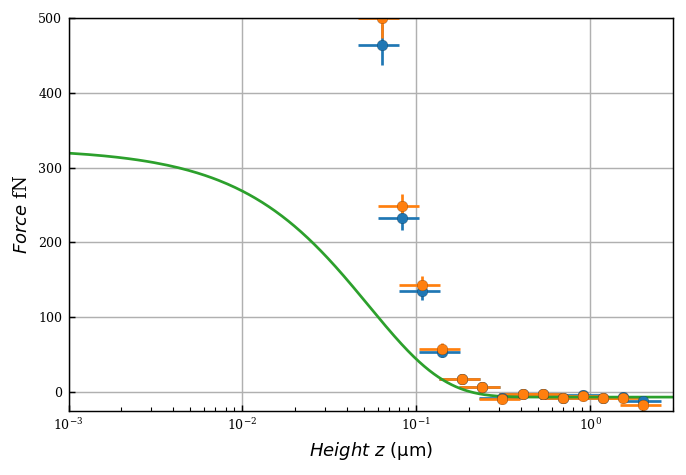

In [148]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))

dataset["z_Force"] = z_F_exp
dataset["Force"] = F_D
dataset["err_Force"] = F_err2
dataset["x_err_Force"] = widths[:-1]

dataset["z_Force_th"] = z_F_th
dataset["Force_th"] = F_th
#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_ronceray*1e15,yerr=F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_D*1e15,yerr=F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,500])
ax.set_xlim([0.1e-2,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

In [149]:
z_F_th = np.linspace(1e-3, 10,100000) * 1e-6

F_EHD_th = 0.41 * 0.001 * 0.001 * 4e-21 / (4/3 * 1050 * np.sqrt(r) * 15e3/3) * z_F_th ** (-5/2) 
F_EHD_th2 = 0.41 * 0.001 * 0.001 * 4e-21 / (4/3 * 1050 * np.sqrt(r) * 1.5e3/3) * z_F_th ** (-5/2) 
F_EHD_th3 = 0.41 * 0.001 * 0.001 * 4e-21 / (4/3 * 1050 * np.sqrt(r) * 28e3/3) * z_F_th ** (-5/2) 
F_suction = F_EHD_th / 0.41 * 0.0005 * r/z_F_th
F_EHD_th =  F_EHD_th #- F_suction
plt.plot(z_F_exp*1e6,F_ronceray*1e15 - F_th_2*1e15, "o", label="D modifié")
plt.plot(z_F_th*1e6, F_EHD_th*1e15)
plt.plot(z_F_th*1e6, F_EHD_th2*1e15)
plt.loglog(z_F_th*1e6, F_EHD_th3*1e15)

plt.plot(z_F_exp*1e6,F_D*1e15 - F_th_2*1e15, "o", label = "D non modifié")
plt.legend()

NameError: name 'F_th_2' is not defined

In [ ]:
plt.plot(F_EHD_th, "o")

In [ ]:
savemat("data_graphs.mat",dataset)

In [ ]:
dataset["err_Force"]

## Redo Multifit

In [ ]:
stop
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer2(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    #offset = x[3]
    #offset_2 = x[4]
    
  
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"], 0, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - np.log(data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / ((np.log(Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = np.log(P_b_off(data["x_pdf_z"], 0, B, ld, lb)) - np.log(data["pdf_z"])
    chi_pdf_z = np.mean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / (np.log(P_b_off(data["x_pdf_z"][E_chi_pdf_z > -np.inf], 0, B, ld, lb))**2))
    
    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = np.log(Dz_z(data["z_D_yacine"], offset)) - np.log(data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / (np.log(Dz_z(data["z_D_yacine"][E_D_z > -np.inf], offset))**2))
    
    E_D_x = np.log(Dx_z_off(data["z_D_yacine"], offset)) - np.log(data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / (np.log(Dx_z_off(data["z_D_yacine"], offset))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    E_F_z = np.nanmean(((Force_th(dataset["z_Force"], B,ld,lb) - (np.abs(dataset["Force"])))**2) /Force_th(dataset["z_Force"], B,ld,lb)**2)

    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t + E_F_z
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 
    
    E_F_z = np.nanmean((((np.abs(Force_th(dataset["z_Force"], B,ld,lb))) - (np.abs(dataset["Force"])))**2) /((np.log(np.abs(Force_th(dataset["z_Force"], B,ld,lb)))**2)) )

    
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_Dz_small_t + E_F_z
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 
    
    

In [ ]:
x0 = [ld,lb,B]
minimizer2(x0)

In [ ]:
from scipy.optimize import leastsq

options={
    'maxc1or': 30, 
    'ftol': 2.220446049250313e-10, 
    'gtol': 1e-5, 
    'eps': 1e-08, 
    'maxfun': 15000, 
    'maxiter': 15000, 
    'maxls': 20, 
    'finite_diff_rel_step': None,
}


#bnds = ((0, 1), (0, 1), (0, 30), (1, None), (1, None),(1, None),(10, 20),(40, 200),(400, 600),(0, 0.1))
bnds = ((10,100),(400,600),(1,10),(0.05),(0,0.05))

res = minimize(minimizer2,
               x0,
               method = "BFGS",
               tol = 0.1e-4,
              )



#res = leastsq(minimizer, x0)


In [ ]:
res

In [ ]:


res.x
results = {
    "ld":res.x[0],
    "lb":res.x[1],
    "B":res.x[2],
    #"offset_diffusion":res.x[3],
    #"offset_boltzmann":res.x[4], 
}

results

In [ ]:
ld = res.x[0]
lb = res.x[1]
B = res.x[2]
#offset_diffusion = res.x[3]
#offset_B = res.x[4]

In [ ]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))


#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15,yerr=0*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,700])
ax.set_xlim([0.1e-1,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

In [ ]:
fig = plt.figure(figsize=(cm2inch(8.6), 1.3*cm2inch(8.6)),constrained_layout=True)
gs = fig.add_gridspec(6,6)


fig.add_subplot(gs[3:5,3:])

plt.plot(dataset["x_pdf_z"] * 1e6,P_b_off(dataset["x_pdf_z"], 0, B, ld, lb))
plt.semilogy(dataset["x_pdf_z"] * 1e6,dataset["pdf_z"], "o", markersize = 2)

plt.xlabel("$z$ ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$P(z)$ (a.u.)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,10])
ax.set_xlim([-0.2,3])
plt.xticks([0,1,2,3])

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()



plt.text(0.9*xmax,1.1*ymin,'a')


##### MSD


fig.add_subplot(gs[0:2,0:])

dataset["MSD_fit_x"] = f(dataset["MSD_time_tot"],dataset["D_para"],0)
dataset["MSD_fit_z"] = f(dataset["MSD_time_tot"],dataset["D_perp"],0)

plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_x"], color = "tab:orange")
plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_z"], color = "tab:green")

plt.loglog(dataset["MSD_time_tot"],dataset["MSD_x_tot"],"o", label = "x", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_y_tot"],"o", label = "y", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_z_tot"],"o", label = "z", markersize = 2)




# plateau
dataset["fitted_MSD_Plateau"] = Theoritical_Plateau(B,ld,lb)

plateau = [dataset["fitted_MSD_Plateau"] for i in range(len(dataset["MSD_time_tot"]))]
plt.loglog(dataset["MSD_time_tot"][-40:], plateau[-40:], color = "tab:green", linewidth = 5, alpha = 0.3)
                               
    
##
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.set_xlim([1e-2,1e3])
ax.set_ylim([None,1e-10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.3*xmax,1.35*ymin,'b')


plt.ylabel("$MSD$ ($\mathrm{m^2}$)",fontsize = "small")
plt.xlabel("$\Delta$t (s)",fontsize = "small")

plt.legend(frameon = False,fontsize = "x-small",loc = "upper left")

##### PDF DZ long time



fig.add_subplot(gs[4:,0:3])

plt.errorbar(dataset["x_pdf_longtime"]*1e6,dataset["pdf_longtime"],yerr=err_long_t,barsabove=True,linewidth = 0.8, label = "experimental pdf",marker="o", markersize=2,capsize = 1,linestyle="")
#plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.semilogy(bins_centers_long_t,Pdeltaz_long(bins_centers_long_t*1e-6, B, ld, lb), linewidth = 1, zorder=-1)


plt.ylabel("$P(\Delta z)$ (a.u.)",fontsize = "small")
plt.xlabel("$\Delta z$ ($\mathrm{\mu m}$)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,1])
#ax.set_xlim([None,1e-10])

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.55*ymax,'c')


#### VISCOSITY

z_th = np.linspace(10e-9,10e-6,100)
dataset["z_D_th"] = z_th
fig.add_subplot(gs[4:,3:])

#plt.errorbar(z_D_para_fit, D_para_fit/Do, yerr = err_d_para_fit/Do, linewidth = 3, marker = "x", linestyle = "",color = "tab:red", label = "$D_ \\parallel$")
dataset["D_x_th"] = Dx_z_off(z_th,0)
plt.loglog(z_th*1e6, dataset["D_x_th"], color = "tab:blue")
plt.plot(dataset["z_D_yacine"]*1e6 - dataset["offset_diffusion"], dataset["z_D_x_yacine"] / Do, marker = "o", linestyle = "",color = "tab:blue",label =  "$D_\\parallel$", markersize = 2)


dataset["D_z_th"] = Dz_z(z_th,0)

#plt.errorbar(bins_center_pdf_z[:-1], Dz[:]/Do, yerr=err[:]/Do, linewidth = 3, marker = "o", linestyle = "",color = "tab:red",label =  "$D_ \\bot$")
plt.semilogx(z_th*1e6, dataset["D_z_th"], color = "tab:green")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion, dataset["z_D_z_yacine"] / Do, marker = "o", linestyle = "",color = "tab:green",label =  "$D_ \\bot$", markersize = 2)


ax = plt.gca()
ax.set_ylim([None,1])
ax.set_xlim([None,10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.4*xmax,1.1*ymin,'d')


#plt.legend(frameon = False,fontsize = "x-small",loc="lower center")
plt.xlabel("z ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$D (z)/ D_\mathrm{0}$",fontsize = "small")



#### Inset

# Inset

#left, bottom, width, height = [0.26, 0.2, 0.15, 0.11]
#ax2 = fig.add_axes([left, bottom, width, height])
fig.add_subplot(gs[2:4,0:3])
I = [1, 4, 5]

for i in I:
    
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:])
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 100)
    hist = hist/np.trapz(hist,bins_center)
    
    if i == I[0]:
        popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(hist), np.std(hist)])
        plt.plot(bins_center, gauss_function(bins_center, *popt), markersize = 4)#, label = "fit at t = {:.2f} s".format(time[i]))
        plt.plot(bins_center, hist, ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]),color = "tab:blue", markersize = 4)
        plt
        continue
    plt.semilogy(bins_center, hist, ".",label = " $\\Delta t = {:.2f}$ s".format(time[i]), markersize = 4)

ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-6.5,6.5])
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())

#plt.legend(fontsize = "xx-small", frameon = False)
plt.ylabel("$P(\Delta x)$ (a.u.)", fontsize = "small")
plt.xlabel("$\Delta x$ ($\mathrm{\mu m}$)", fontsize = "small")


#plt.subplot(3,3,2)
#plt.subplot(3,3,5)
#plt.subplot(3,3,8)

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.25*ymax,'e')

plt.tight_layout(pad = 0.1)

plt.savefig("graphe.pdf",dpi=600)

In [ ]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))


#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15,yerr=0*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,700])
ax.set_xlim([0.1e-1,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

## Comparizzzzon to pdf

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.misc import derivative

x, y = pdf(z_0offset[z_0offset < 2.5]*1e-6,  bins = 30)

x = -np.log(x);x = x - np.min(x)

f = UnivariateSpline(y,x)
f.set_smoothing_factor(0)

In [ ]:
x_dev = np.linspace(1e-9,1e-6,1000)

F_expexp = - derivative(f,x_dev,dx=1e-10) * 4e-21

In [ ]:
bins = np.cumsum(widths[::-1])
widths2 = (bins[1:] - bins[:-1])

# On the n - r measurement

In [ ]:
stop

n_r = np.fromfile('find_nrfit_result_dur_27052020_n_r_fix_0p0513_wav_532.dat', dtype=np.float64)
n_r = n_r.reshape(len(n_r)//10,10)
r = n_r[:,3]
n = n_r[:,4]

In [ ]:
H, xedges, yedges = np.histogram2d(n, r, bins=100)
H = H.T  # Let each row list bins with common y range.

In [ ]:
plt.hist2d(r,n, bins = 150)
plt.ylabel("n")
plt.xlabel("r [$\mathrm{\mu m}$]")

In [ ]:
plt.hist2d(r[(r>1.42) & (r<1.48)],n[(r>1.42) & (r<1.48)], bins = 150)
plt.ylabel("n")
plt.xlabel("r [$\mathrm{\mu m}$]")

In [ ]:
r[(r>1.4) & (r<1.5)]

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.ticker as ticker

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>1.445) & (r<1.465)]
y = n[(r>1.445) & (r<1.465)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)



In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=0.16, bottom=.20, right=.99, top=.99)
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.clabel(cset, inline=1, fontsize=4, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_xlabel("r [$\mathrm{\mu m}$]")
ax.set_ylabel("n")
#plt.title("KDE r n")
fig.set_size_inches(cm2inch(8.6), cm2inch(8.6/1.618))
fig.savefig('KDErn.pdf')
#pl.show()

In [ ]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f > 0.2)]), np.std(yy[np.where(f > 0.2)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f > 0.2)]), np.std(xx[np.where(f > 0.2)])))


In [ ]:
1e-3 / (3600*24*9)

In [ ]:
min(data["x_pdf_z"])

In [ ]:
5*4e-21/70e-9*1e12

In [ ]:
data

In [ ]:
print(plt.style.available)

In [ ]:
vz,verr = vzz()

In [ ]:


    
plt.plot(z_z[2:-2],Dzs, "o")

In [ ]:
z = z_0offset* 1e-6
Y = bins_center_pdf_z * 1e-6
z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.  
Dzs = (z_z[2:] - z_z[:-2])/(2/fps)

plt.hist2d(z_z[1:-1],Dzs, bins = 300)
plt.ylabel("v")
plt.xlabel("z")
ax = plt.gca()
ax.set_ylim([-2e-6,+2e-6])
ax.set_xlim([0,1e-6])

In [ ]:
z = z_0offset* 1e-6
Y = bins_center_pdf_z * 1e-6
z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.  
Dzs = (z_z[2:] - z_z[:-2])/(2/fps)

plt.hist2d(z_z[:-2],Dzs, bins  = 300)
plt.ylabel("v")
plt.xlabel("z")
ax = plt.gca()
ax.set_ylim([-2e-6,+2e-6])
ax.set_xlim([0,1e-6])

In [ ]:
plt.plot(x,y)

In [ ]:
plt.plot(y)

In [ ]:
len(x)

In [ ]:
np.diff(z_F_exp)[0]

In [ ]:
dataset["Dz"][0]*Do

In [ ]:
# Dt = widthbin**2 
t_max_calcul_Force = np.diff(z_F_exp)[0]**2/dataset["Dz"][0]/Do

In [ ]:
t_max_calcul_Force

In [ ]:
time[2]

In [ ]:
dataset

In [ ]:
dataset

In [ ]:
dataset["r"]

In [ ]:
n

In [ ]:
dataset["z_D_x_yacine"]

In [ ]:
t

In [ ]:
t = 2
plt.figure()
for t in [1,2,3,4,5]:
    DX = x[:-t] - x[t:]
    DZ = z[:-t] - z[t:]
    zzz = z_dedrift[t:]
    nb_points = 20
    len_z = np.max(zzz) - np.min(zzz)
    len_z = len_z / nb_points

    MXZ = np.zeros(nb_points)
    z_plot = np.zeros(nb_points)

    for i in range(nb_points):
        dx = DX[(zzz > i*len_z) & (zzz < (i+1)*len_z)]
        dx = dx / np.std(dx)
        dz = DZ[(zzz > i*len_z) & (zzz < (i+1)*len_z)]
        dz = dz / np.std(dz)
        z_plot[i] = np.mean(zzz[(zzz > i*len_z) & (zzz < (i+1)*len_z)])

        MXZ[i] = np.mean(dx*dz)
        
    plt.loglog(z_plot, -MXZ, "o", label = str(t))
    plt.xlim((None,1))
    
plt.legend()
    


In [ ]:
plt.loglog(z_plot, -MXZ, "o")
plt.xlim((None,1))

In [ ]:
plt.plot(z_plot)

In [ ]:
i=0
a = DX[(zzz > i*len_z) & (zzz < (i+1)*len_z)]

In [ ]:
b = DZ[(zzz > i*len_z) & (zzz < (i+1)*len_z)]

In [ ]:
np.mean(a*b)

In [ ]:
i = 0
plt.plot(zzz[(zzz > i*len_z) & (zzz < (i+1)*len_z)])

In [ ]:
for i in range(len(z_plot)):
    z_plot[i]= np.mean(zzz[(zzz > i*len_z) & (zzz < (i+1)*len_z)])

In [ ]:
z_plot